In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Medical_report_generation_2023/Reboot")   

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

In [ ]:
train_dataset.shape

(2758, 4)

In [ ]:
chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))
#chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3), pooling="avg") --> give u a 1024 length
                                                                                                            #feature vector

In [ ]:
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)

In [ ]:
# This contains weights for the CheXNet network
# It has the weight  for the last layer of the chexnet network as well, therefore an additional layer is added in the
# previous cell block to fit the weights which can be removed later.
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [ ]:
model = Model(inputs = model.input, outputs = model.layers[-2].output)
# model.summary will show you all the layers in the model

In [ ]:
model.save('chexnet.h5',save_format='h5')

In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    
    return X

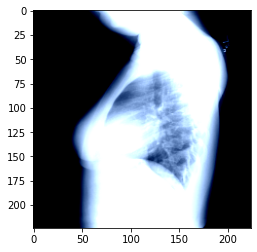

In [ ]:
img = load_image('/content/drive/MyDrive/Medical_report_generation_2023/NLMCXR_png/CXR1_1_IM-0001-3001.png')
plt.imshow(img[0])

In [ ]:
os.chdir('/content/drive/MyDrive/Medical_report_generation_2023/NLMCXR_png')

In [ ]:
def image_features(train, test, cv):
    Xnet_features_attention = {}
    
    for key, img1, img2, finding in tqdm(train.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
    
    for key, img1, img2, finding in tqdm(test.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    for key, img1, img2, finding in tqdm(cv.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
        
    return Xnet_features_attention

In [ ]:
train_dataset

,Person_id,Image1,Image2,Report
0,CXR1_1_IM-0001_0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,startseq the cardiac silhouette and mediastinu...
1,CXR10_IM-0002_0,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,startseq the cardiomediastinal silhouette with...
2,CXR100_IM-0002_0,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,startseq both lungs are clear and epanded . h...
3,CXR1000_IM-0003_0,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,startseq there increased opacity within the ri...
4,CXR1000_IM-0003_1,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-3001.png,startseq there increased opacity within the ri...
...,...,...,...,...
2753,CXR3682_IM-1834_0,CXR3682_IM-1834-1001.png,CXR3682_IM-1834-2001.png,startseq the lungs are hypoventilated . there...
2754,CXR3683_IM-1835_0,CXR3683_IM-1835-3001.png,CXR3683_IM-1835-4001.png,startseq eamination was performed with nipple ...
2755,CXR3685_IM-1836_0,CXR3685_IM-1836-1001.png,CXR3685_IM-1836-1002.png,startseq calcified thoracic aorta . mild righ...
2756,CXR3687_IM-1838_0,CXR3687_IM-1838-1001.png,CXR3687_IM-1838-2001.png,startseq heart size and mediastinal contours a...


In [ ]:
Xnet_features_attention = image_features(train_dataset, test_dataset, cv_dataset)

  0%|          | 0/2758 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 1/2758 [00:09<7:33:11,  9.86s/it]

1/1 [==============================] - 0s 76ms/step


  0%|          | 2/2758 [00:10<3:35:11,  4.68s/it]

1/1 [==============================] - 0s 83ms/step


  0%|          | 3/2758 [00:12<2:28:50,  3.24s/it]

1/1 [==============================] - 0s 46ms/step


  0%|          | 4/2758 [00:13<1:55:44,  2.52s/it]

1/1 [==============================] - 0s 50ms/step


  0%|          | 5/2758 [00:14<1:24:34,  1.84s/it]

1/1 [==============================] - 0s 46ms/step


  0%|          | 6/2758 [00:14<1:01:07,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


  0%|          | 7/2758 [00:16<58:25,  1.27s/it]  

1/1 [==============================] - 0s 49ms/step


  0%|          | 8/2758 [00:16<51:24,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


  0%|          | 9/2758 [00:18<53:29,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


  0%|          | 10/2758 [00:19<56:43,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


  0%|          | 11/2758 [00:20<56:58,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


  0%|          | 12/2758 [00:21<56:33,  1.24s/it]

1/1 [==============================] - 0s 75ms/step


  0%|          | 13/2758 [00:22<48:49,  1.07s/it]

1/1 [==============================] - 0s 88ms/step


  1%|          | 14/2758 [00:23<40:28,  1.13it/s]

1/1 [==============================] - 0s 89ms/step


  1%|          | 15/2758 [00:24<48:31,  1.06s/it]

1/1 [==============================] - 0s 92ms/step


  1%|          | 16/2758 [00:26<56:45,  1.24s/it]

1/1 [==============================] - 0s 49ms/step


  1%|          | 17/2758 [00:27<1:00:46,  1.33s/it]

1/1 [==============================] - 0s 48ms/step


  1%|          | 18/2758 [00:28<56:45,  1.24s/it]  

1/1 [==============================] - 0s 49ms/step


  1%|          | 19/2758 [00:30<1:00:11,  1.32s/it]

1/1 [==============================] - 0s 48ms/step


  1%|          | 20/2758 [00:31<52:59,  1.16s/it]  

1/1 [==============================] - 0s 54ms/step


  1%|          | 21/2758 [00:32<51:01,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


  1%|          | 22/2758 [00:33<51:18,  1.13s/it]

1/1 [==============================] - 0s 51ms/step


  1%|          | 23/2758 [00:34<48:36,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


  1%|          | 24/2758 [00:35<51:13,  1.12s/it]

1/1 [==============================] - 0s 59ms/step


  1%|          | 25/2758 [00:36<54:41,  1.20s/it]

1/1 [==============================] - 0s 221ms/step


  1%|          | 26/2758 [00:38<1:06:38,  1.46s/it]

1/1 [==============================] - 0s 81ms/step


  1%|          | 27/2758 [00:40<1:03:55,  1.40s/it]

1/1 [==============================] - 0s 49ms/step


  1%|          | 28/2758 [00:41<1:00:38,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


  1%|          | 29/2758 [00:42<59:37,  1.31s/it]  

1/1 [==============================] - 0s 48ms/step


  1%|          | 30/2758 [00:43<58:54,  1.30s/it]

1/1 [==============================] - 0s 46ms/step


  1%|          | 31/2758 [00:44<52:14,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


  1%|          | 32/2758 [00:45<53:49,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


  1%|          | 33/2758 [00:46<48:15,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


  1%|          | 34/2758 [00:47<49:32,  1.09s/it]

1/1 [==============================] - 0s 50ms/step


  1%|▏         | 35/2758 [00:49<53:01,  1.17s/it]

1/1 [==============================] - 0s 54ms/step


  1%|▏         | 36/2758 [00:50<55:05,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


  1%|▏         | 37/2758 [00:51<55:10,  1.22s/it]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 38/2758 [00:53<56:21,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 39/2758 [00:54<56:10,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 40/2758 [00:55<54:58,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 41/2758 [00:56<53:24,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 42/2758 [00:57<51:14,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 43/2758 [00:58<55:27,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 44/2758 [00:59<49:51,  1.10s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 45/2758 [01:00<46:52,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 46/2758 [01:02<52:18,  1.16s/it]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 47/2758 [01:03<56:24,  1.25s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 48/2758 [01:05<1:01:22,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 49/2758 [01:06<59:18,  1.31s/it]  

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 50/2758 [01:07<55:11,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 51/2758 [01:08<55:08,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 52/2758 [01:09<53:53,  1.20s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 53/2758 [01:11<55:10,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 54/2758 [01:12<55:10,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 55/2758 [01:13<57:48,  1.28s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 56/2758 [01:14<57:47,  1.28s/it]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 57/2758 [01:16<59:23,  1.32s/it]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 58/2758 [01:17<58:15,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 59/2758 [01:18<58:39,  1.30s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 60/2758 [01:20<55:33,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 61/2758 [01:21<52:09,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 62/2758 [01:21<49:31,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 63/2758 [01:22<38:36,  1.16it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 64/2758 [01:23<44:25,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 65/2758 [01:24<48:42,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 66/2758 [01:25<43:38,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 67/2758 [01:26<46:34,  1.04s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 68/2758 [01:28<51:20,  1.15s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 69/2758 [01:29<54:51,  1.22s/it]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 70/2758 [01:30<50:15,  1.12s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 71/2758 [01:31<50:12,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 72/2758 [01:32<43:52,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 73/2758 [01:33<46:16,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 74/2758 [01:34<52:45,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 75/2758 [01:35<47:05,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 76/2758 [01:36<47:35,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 77/2758 [01:38<50:50,  1.14s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 78/2758 [01:38<45:58,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 79/2758 [01:40<49:04,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 80/2758 [01:41<49:01,  1.10s/it]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 81/2758 [01:42<50:40,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 82/2758 [01:43<54:32,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 83/2758 [01:44<51:22,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 84/2758 [01:45<48:25,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 85/2758 [01:46<47:01,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 86/2758 [01:47<46:43,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 87/2758 [01:48<48:09,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 88/2758 [01:49<44:02,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 89/2758 [01:50<42:14,  1.05it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 90/2758 [01:51<43:48,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 91/2758 [01:52<47:48,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 92/2758 [01:54<49:31,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 93/2758 [01:55<49:46,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 94/2758 [01:56<52:17,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 95/2758 [01:57<52:14,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 96/2758 [01:58<50:51,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 97/2758 [02:00<55:10,  1.24s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 98/2758 [02:01<53:29,  1.21s/it]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 99/2758 [02:02<53:05,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 100/2758 [02:03<52:27,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 101/2758 [02:04<46:14,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 102/2758 [02:05<43:05,  1.03it/s]

1/1 [==============================] - 0s 56ms/step


  4%|▎         | 103/2758 [02:06<44:27,  1.00s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 104/2758 [02:07<43:58,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 105/2758 [02:08<48:04,  1.09s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 106/2758 [02:09<46:28,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 107/2758 [02:10<47:39,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 108/2758 [02:11<47:18,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 109/2758 [02:12<46:51,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 110/2758 [02:13<43:26,  1.02it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 111/2758 [02:14<35:04,  1.26it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 112/2758 [02:15<38:27,  1.15it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 113/2758 [02:15<35:33,  1.24it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 114/2758 [02:16<33:19,  1.32it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 115/2758 [02:16<27:12,  1.62it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 116/2758 [02:16<23:22,  1.88it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 117/2758 [02:17<20:05,  2.19it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 118/2758 [02:18<29:01,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 119/2758 [02:19<37:45,  1.16it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 120/2758 [02:20<42:37,  1.03it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 121/2758 [02:21<42:39,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 122/2758 [02:22<42:45,  1.03it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 123/2758 [02:24<44:33,  1.01s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 124/2758 [02:25<45:02,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 125/2758 [02:26<46:11,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 126/2758 [02:27<45:49,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 127/2758 [02:27<41:35,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 128/2758 [02:29<45:52,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 129/2758 [02:30<47:17,  1.08s/it]

1/1 [==============================] - 0s 78ms/step


  5%|▍         | 130/2758 [02:31<51:07,  1.17s/it]

1/1 [==============================] - 0s 55ms/step


  5%|▍         | 131/2758 [02:32<52:07,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 132/2758 [02:34<50:24,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


  5%|▍         | 133/2758 [02:34<43:24,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 134/2758 [02:35<43:06,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 135/2758 [02:36<46:37,  1.07s/it]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 136/2758 [02:37<36:29,  1.20it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 137/2758 [02:37<34:04,  1.28it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 138/2758 [02:38<28:01,  1.56it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▌         | 139/2758 [02:39<32:59,  1.32it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 140/2758 [02:40<36:38,  1.19it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 141/2758 [02:41<38:53,  1.12it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 142/2758 [02:42<39:53,  1.09it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 143/2758 [02:42<37:46,  1.15it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▌         | 144/2758 [02:44<42:37,  1.02it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 145/2758 [02:45<44:37,  1.02s/it]

1/1 [==============================] - 0s 72ms/step


  5%|▌         | 146/2758 [02:45<36:52,  1.18it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 147/2758 [02:46<40:11,  1.08it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 148/2758 [02:47<42:26,  1.02it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 149/2758 [02:48<42:46,  1.02it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▌         | 150/2758 [02:50<45:01,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 151/2758 [02:51<44:37,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 152/2758 [02:52<44:36,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 153/2758 [02:53<43:47,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 154/2758 [02:54<44:14,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 155/2758 [02:55<43:40,  1.01s/it]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 156/2758 [02:56<43:49,  1.01s/it]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 157/2758 [02:57<50:22,  1.16s/it]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 158/2758 [02:58<50:49,  1.17s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 159/2758 [02:59<50:16,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 160/2758 [03:00<47:44,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 161/2758 [03:02<50:58,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 162/2758 [03:03<48:49,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 163/2758 [03:04<44:04,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 164/2758 [03:05<43:58,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 165/2758 [03:06<43:44,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 166/2758 [03:07<43:47,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 167/2758 [03:08<44:18,  1.03s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 168/2758 [03:09<41:48,  1.03it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 169/2758 [03:10<47:37,  1.10s/it]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 170/2758 [03:11<50:21,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 171/2758 [03:12<45:19,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 172/2758 [03:13<46:29,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 173/2758 [03:14<47:33,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 174/2758 [03:15<46:32,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 175/2758 [03:16<45:16,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 176/2758 [03:17<44:43,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 177/2758 [03:18<43:47,  1.02s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 178/2758 [03:20<47:19,  1.10s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▋         | 179/2758 [03:21<47:48,  1.11s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 180/2758 [03:22<44:55,  1.05s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 181/2758 [03:23<48:08,  1.12s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 182/2758 [03:24<44:57,  1.05s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 183/2758 [03:24<37:36,  1.14it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 184/2758 [03:25<39:37,  1.08it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 185/2758 [03:26<37:48,  1.13it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 186/2758 [03:27<39:53,  1.07it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 187/2758 [03:28<43:32,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 188/2758 [03:30<48:04,  1.12s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 189/2758 [03:31<48:16,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 190/2758 [03:32<51:01,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 191/2758 [03:33<51:29,  1.20s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 192/2758 [03:35<54:24,  1.27s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 193/2758 [03:36<53:23,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 194/2758 [03:37<51:14,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 195/2758 [03:38<51:06,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 196/2758 [03:39<48:49,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 197/2758 [03:40<47:06,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 198/2758 [03:41<45:55,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 199/2758 [03:43<46:20,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 200/2758 [03:43<41:53,  1.02it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 201/2758 [03:45<45:59,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 202/2758 [03:45<40:36,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 203/2758 [03:45<32:05,  1.33it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 204/2758 [03:47<39:30,  1.08it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 205/2758 [03:48<46:21,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 206/2758 [03:49<47:00,  1.11s/it]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 207/2758 [03:50<45:18,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 208/2758 [03:51<44:19,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 209/2758 [03:52<43:20,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 210/2758 [03:53<43:12,  1.02s/it]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 211/2758 [03:54<44:27,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 212/2758 [03:56<45:23,  1.07s/it]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 213/2758 [03:57<45:04,  1.06s/it]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 214/2758 [03:58<47:57,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 215/2758 [03:59<46:27,  1.10s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 216/2758 [04:00<50:23,  1.19s/it]

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 217/2758 [04:02<50:17,  1.19s/it]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 218/2758 [04:03<53:59,  1.28s/it]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 219/2758 [04:04<53:17,  1.26s/it]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 220/2758 [04:05<48:53,  1.16s/it]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 221/2758 [04:05<38:06,  1.11it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 222/2758 [04:07<42:52,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 223/2758 [04:08<42:49,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 224/2758 [04:09<43:43,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 225/2758 [04:10<43:07,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 226/2758 [04:11<44:05,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 227/2758 [04:12<43:23,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 228/2758 [04:13<42:22,  1.00s/it]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 229/2758 [04:14<39:35,  1.06it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 230/2758 [04:15<42:29,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 231/2758 [04:16<44:44,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 232/2758 [04:17<45:16,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 233/2758 [04:18<45:11,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 234/2758 [04:19<41:18,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 235/2758 [04:19<33:05,  1.27it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▊         | 236/2758 [04:20<36:49,  1.14it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 237/2758 [04:21<39:39,  1.06it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▊         | 238/2758 [04:23<41:05,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▊         | 239/2758 [04:23<38:59,  1.08it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▊         | 240/2758 [04:24<39:35,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 241/2758 [04:26<43:20,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 242/2758 [04:27<43:24,  1.03s/it]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 243/2758 [04:28<45:04,  1.08s/it]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 244/2758 [04:29<46:01,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 245/2758 [04:30<45:27,  1.09s/it]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 246/2758 [04:31<47:20,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 247/2758 [04:32<46:27,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 248/2758 [04:33<46:09,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 249/2758 [04:35<46:30,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 250/2758 [04:36<45:00,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 251/2758 [04:36<40:56,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 252/2758 [04:37<41:09,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 253/2758 [04:38<39:54,  1.05it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 254/2758 [04:39<41:13,  1.01it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 255/2758 [04:40<43:00,  1.03s/it]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 256/2758 [04:41<40:38,  1.03it/s]

1/1 [==============================] - 0s 72ms/step


  9%|▉         | 257/2758 [04:42<34:24,  1.21it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 258/2758 [04:43<40:33,  1.03it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 259/2758 [04:44<41:03,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 260/2758 [04:45<41:35,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 261/2758 [04:46<42:02,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 262/2758 [04:47<42:05,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 263/2758 [04:48<41:58,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 264/2758 [04:49<45:37,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 265/2758 [04:51<46:47,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 10%|▉         | 266/2758 [04:52<45:32,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 10%|▉         | 267/2758 [04:53<49:01,  1.18s/it]

1/1 [==============================] - 0s 57ms/step


 10%|▉         | 268/2758 [04:54<49:34,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 269/2758 [04:55<45:58,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 270/2758 [04:56<44:47,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 271/2758 [04:57<39:26,  1.05it/s]

1/1 [==============================] - 0s 54ms/step


 10%|▉         | 272/2758 [04:58<39:21,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 273/2758 [04:59<42:18,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


 10%|▉         | 274/2758 [05:00<37:48,  1.09it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 275/2758 [05:00<30:32,  1.36it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 276/2758 [05:01<34:38,  1.19it/s]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 277/2758 [05:02<38:12,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 278/2758 [05:03<41:32,  1.01s/it]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 279/2758 [05:04<43:32,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 280/2758 [05:06<45:02,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 281/2758 [05:07<46:21,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 282/2758 [05:08<46:49,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 283/2758 [05:09<47:58,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 284/2758 [05:10<46:08,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 285/2758 [05:11<44:53,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 286/2758 [05:12<45:26,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 287/2758 [05:14<48:09,  1.17s/it]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 288/2758 [05:15<46:23,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 10%|█         | 289/2758 [05:16<44:46,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 290/2758 [05:16<40:22,  1.02it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 291/2758 [05:17<32:13,  1.28it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 292/2758 [05:18<36:29,  1.13it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 293/2758 [05:19<40:23,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 294/2758 [05:20<40:19,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 295/2758 [05:21<41:52,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 296/2758 [05:22<41:41,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 297/2758 [05:23<38:38,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 298/2758 [05:24<40:14,  1.02it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 299/2758 [05:25<40:08,  1.02it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 300/2758 [05:26<38:43,  1.06it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 301/2758 [05:27<40:06,  1.02it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 302/2758 [05:28<35:59,  1.14it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 303/2758 [05:28<28:47,  1.42it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 304/2758 [05:29<35:31,  1.15it/s]

1/1 [==============================] - 0s 74ms/step


 11%|█         | 305/2758 [05:30<38:40,  1.06it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 306/2758 [05:31<41:26,  1.01s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 307/2758 [05:33<44:36,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 308/2758 [05:34<40:34,  1.01it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 309/2758 [05:35<40:54,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 310/2758 [05:36<44:34,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 311/2758 [05:37<43:04,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 11%|█▏        | 312/2758 [05:38<42:01,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 313/2758 [05:39<41:48,  1.03s/it]

1/1 [==============================] - 0s 61ms/step


 11%|█▏        | 314/2758 [05:39<37:34,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 315/2758 [05:40<35:58,  1.13it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 316/2758 [05:41<37:38,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 317/2758 [05:42<38:58,  1.04it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 318/2758 [05:44<42:04,  1.03s/it]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 319/2758 [05:45<47:44,  1.17s/it]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 320/2758 [05:46<44:43,  1.10s/it]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 321/2758 [05:46<34:57,  1.16it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 322/2758 [05:48<39:57,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 323/2758 [05:49<40:33,  1.00it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 324/2758 [05:50<44:12,  1.09s/it]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 325/2758 [05:51<40:23,  1.00it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 326/2758 [05:52<43:56,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 327/2758 [05:53<44:19,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 328/2758 [05:54<44:04,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 329/2758 [05:55<42:48,  1.06s/it]

1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 330/2758 [05:56<43:19,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 331/2758 [05:57<41:22,  1.02s/it]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 332/2758 [05:58<45:07,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 333/2758 [05:59<43:30,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 334/2758 [06:00<42:37,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 335/2758 [06:02<45:16,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 336/2758 [06:03<44:19,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 337/2758 [06:03<38:51,  1.04it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 338/2758 [06:04<38:41,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 339/2758 [06:05<37:09,  1.09it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 340/2758 [06:06<39:52,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 341/2758 [06:08<43:02,  1.07s/it]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 342/2758 [06:09<44:54,  1.12s/it]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 343/2758 [06:10<42:26,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 344/2758 [06:11<44:30,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 345/2758 [06:12<46:21,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 346/2758 [06:13<41:11,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 347/2758 [06:13<32:45,  1.23it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 348/2758 [06:15<38:39,  1.04it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 349/2758 [06:15<36:57,  1.09it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 350/2758 [06:17<42:06,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 351/2758 [06:18<41:13,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 352/2758 [06:19<40:57,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 353/2758 [06:20<37:52,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 354/2758 [06:20<36:08,  1.11it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 355/2758 [06:22<42:10,  1.05s/it]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 356/2758 [06:23<40:59,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 357/2758 [06:24<41:34,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 358/2758 [06:25<43:06,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 359/2758 [06:26<43:31,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 360/2758 [06:27<42:38,  1.07s/it]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 361/2758 [06:28<44:47,  1.12s/it]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 362/2758 [06:29<44:58,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 363/2758 [06:30<43:08,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 364/2758 [06:31<38:25,  1.04it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 365/2758 [06:31<30:34,  1.30it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 366/2758 [06:32<33:52,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 367/2758 [06:33<35:09,  1.13it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 368/2758 [06:35<37:54,  1.05it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 369/2758 [06:36<42:07,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 370/2758 [06:37<44:45,  1.12s/it]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 371/2758 [06:38<43:08,  1.08s/it]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 372/2758 [06:39<43:03,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█▎        | 373/2758 [06:40<42:18,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 374/2758 [06:42<45:23,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 375/2758 [06:43<43:40,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 376/2758 [06:43<39:15,  1.01it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 377/2758 [06:44<40:14,  1.01s/it]

1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 378/2758 [06:45<35:50,  1.11it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 379/2758 [06:45<28:45,  1.38it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 380/2758 [06:46<33:16,  1.19it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 381/2758 [06:48<38:02,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 382/2758 [06:49<40:31,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 383/2758 [06:50<43:47,  1.11s/it]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 384/2758 [06:51<42:13,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 385/2758 [06:52<44:40,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 386/2758 [06:53<42:38,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 387/2758 [06:54<41:09,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 388/2758 [06:55<40:19,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 389/2758 [06:56<40:33,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 390/2758 [06:57<41:01,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 14%|█▍        | 391/2758 [06:58<41:47,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 392/2758 [07:00<48:07,  1.22s/it]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 393/2758 [07:01<48:12,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 394/2758 [07:02<46:35,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 395/2758 [07:03<45:19,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 396/2758 [07:05<44:58,  1.14s/it]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 397/2758 [07:06<43:05,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 398/2758 [07:07<41:31,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 399/2758 [07:07<40:26,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 400/2758 [07:09<41:09,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 401/2758 [07:10<40:52,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 402/2758 [07:11<40:34,  1.03s/it]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 403/2758 [07:12<41:04,  1.05s/it]

1/1 [==============================] - 0s 57ms/step


 15%|█▍        | 404/2758 [07:13<42:01,  1.07s/it]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 405/2758 [07:14<42:02,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 406/2758 [07:15<38:08,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 407/2758 [07:16<38:19,  1.02it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 408/2758 [07:17<41:25,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 409/2758 [07:18<45:21,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 410/2758 [07:19<45:02,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 411/2758 [07:21<45:10,  1.15s/it]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 412/2758 [07:22<47:11,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 413/2758 [07:23<44:40,  1.14s/it]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 414/2758 [07:24<40:28,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 415/2758 [07:25<42:16,  1.08s/it]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 416/2758 [07:26<43:24,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 417/2758 [07:27<41:42,  1.07s/it]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 418/2758 [07:28<40:32,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 419/2758 [07:29<36:39,  1.06it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 420/2758 [07:29<29:00,  1.34it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 421/2758 [07:30<33:44,  1.15it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 422/2758 [07:31<37:25,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 423/2758 [07:32<37:35,  1.04it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 424/2758 [07:33<37:41,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 425/2758 [07:34<38:34,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 426/2758 [07:35<36:06,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 427/2758 [07:36<37:04,  1.05it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 428/2758 [07:37<41:16,  1.06s/it]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 429/2758 [07:39<43:27,  1.12s/it]

1/1 [==============================] - 0s 90ms/step


 16%|█▌        | 430/2758 [07:40<44:39,  1.15s/it]

1/1 [==============================] - 0s 81ms/step


 16%|█▌        | 431/2758 [07:41<47:33,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 432/2758 [07:42<45:05,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 433/2758 [07:43<42:55,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 434/2758 [07:45<47:46,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 435/2758 [07:46<48:07,  1.24s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 436/2758 [07:47<45:15,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 437/2758 [07:48<46:38,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 438/2758 [07:49<42:23,  1.10s/it]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 439/2758 [07:51<45:20,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 440/2758 [07:52<44:55,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 441/2758 [07:53<47:48,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 442/2758 [07:54<44:39,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 443/2758 [07:55<40:25,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 444/2758 [07:56<40:13,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 445/2758 [07:57<42:13,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 446/2758 [07:58<43:06,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 447/2758 [07:59<39:04,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 448/2758 [08:00<40:05,  1.04s/it]

1/1 [==============================] - 0s 52ms/step


 16%|█▋        | 449/2758 [08:01<39:18,  1.02s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█▋        | 450/2758 [08:02<38:52,  1.01s/it]

1/1 [==============================] - 0s 72ms/step


 16%|█▋        | 451/2758 [08:03<39:32,  1.03s/it]

1/1 [==============================] - 0s 67ms/step


 16%|█▋        | 452/2758 [08:04<41:08,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 453/2758 [08:06<42:39,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 454/2758 [08:07<41:27,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 16%|█▋        | 455/2758 [08:08<42:13,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 456/2758 [08:09<40:50,  1.06s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 457/2758 [08:09<37:14,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 458/2758 [08:10<37:08,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 459/2758 [08:11<37:00,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 460/2758 [08:12<36:59,  1.04it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 461/2758 [08:14<39:01,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 462/2758 [08:14<37:13,  1.03it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 463/2758 [08:15<37:58,  1.01it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 464/2758 [08:17<42:20,  1.11s/it]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 465/2758 [08:18<44:56,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 466/2758 [08:19<46:16,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 467/2758 [08:21<44:49,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 468/2758 [08:22<42:46,  1.12s/it]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 469/2758 [08:23<41:47,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 470/2758 [08:24<42:06,  1.10s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 471/2758 [08:25<41:01,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 472/2758 [08:26<43:07,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 473/2758 [08:27<41:45,  1.10s/it]

1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 474/2758 [08:28<43:59,  1.16s/it]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 475/2758 [08:29<41:48,  1.10s/it]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 476/2758 [08:30<42:25,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 477/2758 [08:31<42:13,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 478/2758 [08:32<36:57,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 479/2758 [08:32<29:17,  1.30it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 480/2758 [08:34<35:13,  1.08it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 481/2758 [08:35<39:25,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 482/2758 [08:36<39:13,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 483/2758 [08:37<35:36,  1.07it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 484/2758 [08:38<36:47,  1.03it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 485/2758 [08:39<40:24,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 486/2758 [08:40<40:58,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 487/2758 [08:41<42:12,  1.12s/it]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 488/2758 [08:43<43:33,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 489/2758 [08:44<42:50,  1.13s/it]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 490/2758 [08:44<38:14,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 491/2758 [08:46<41:02,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 492/2758 [08:47<39:52,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 493/2758 [08:48<39:05,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 494/2758 [08:49<38:20,  1.02s/it]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 495/2758 [08:50<38:39,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 496/2758 [08:50<35:23,  1.07it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 497/2758 [08:52<37:21,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 498/2758 [08:53<37:16,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 499/2758 [08:54<37:33,  1.00it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 500/2758 [08:54<35:43,  1.05it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 501/2758 [08:55<30:36,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 502/2758 [08:56<34:43,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 503/2758 [08:57<37:25,  1.00it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 504/2758 [08:58<37:49,  1.01s/it]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 505/2758 [08:59<38:22,  1.02s/it]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 506/2758 [09:00<39:00,  1.04s/it]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 507/2758 [09:01<38:43,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 508/2758 [09:03<40:31,  1.08s/it]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 509/2758 [09:04<40:16,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 510/2758 [09:05<41:22,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 511/2758 [09:06<40:32,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 512/2758 [09:07<40:46,  1.09s/it]

1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 513/2758 [09:08<45:13,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 514/2758 [09:10<46:17,  1.24s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 515/2758 [09:11<45:57,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 516/2758 [09:12<44:05,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 517/2758 [09:13<43:43,  1.17s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 518/2758 [09:14<42:15,  1.13s/it]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 519/2758 [09:15<37:13,  1.00it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 520/2758 [09:15<29:41,  1.26it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 521/2758 [09:16<34:03,  1.09it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 522/2758 [09:18<41:26,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 523/2758 [09:19<42:46,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 524/2758 [09:20<42:46,  1.15s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 525/2758 [09:22<43:10,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 526/2758 [09:23<41:02,  1.10s/it]

1/1 [==============================] - 0s 63ms/step


 19%|█▉        | 527/2758 [09:24<40:41,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 528/2758 [09:25<40:12,  1.08s/it]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 529/2758 [09:26<39:53,  1.07s/it]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 530/2758 [09:27<39:09,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 531/2758 [09:28<38:42,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 532/2758 [09:29<39:55,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 533/2758 [09:30<38:52,  1.05s/it]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 534/2758 [09:31<40:01,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 535/2758 [09:32<41:36,  1.12s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 536/2758 [09:33<41:43,  1.13s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 537/2758 [09:35<43:47,  1.18s/it]

1/1 [==============================] - 0s 65ms/step


 20%|█▉        | 538/2758 [09:36<42:32,  1.15s/it]

1/1 [==============================] - 0s 61ms/step


 20%|█▉        | 539/2758 [09:37<40:53,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 540/2758 [09:38<39:38,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 541/2758 [09:38<35:02,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 542/2758 [09:39<27:42,  1.33it/s]

1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 543/2758 [09:40<28:30,  1.29it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 544/2758 [09:41<31:09,  1.18it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 545/2758 [09:41<29:27,  1.25it/s]

1/1 [==============================] - 0s 48ms/step


 20%|█▉        | 546/2758 [09:42<23:49,  1.55it/s]

1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 547/2758 [09:43<27:52,  1.32it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 548/2758 [09:44<31:49,  1.16it/s]

1/1 [==============================] - 0s 72ms/step


 20%|█▉        | 549/2758 [09:44<29:24,  1.25it/s]

1/1 [==============================] - 0s 54ms/step


 20%|█▉        | 550/2758 [09:45<29:43,  1.24it/s]

1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 551/2758 [09:46<25:41,  1.43it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 552/2758 [09:46<23:40,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 553/2758 [09:47<22:09,  1.66it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 554/2758 [09:48<27:29,  1.34it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 555/2758 [09:49<28:11,  1.30it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 556/2758 [09:50<31:23,  1.17it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 557/2758 [09:51<33:49,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 558/2758 [09:52<34:59,  1.05it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 559/2758 [09:53<35:20,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 560/2758 [09:54<35:39,  1.03it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 561/2758 [09:55<36:42,  1.00s/it]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 562/2758 [09:56<36:07,  1.01it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 563/2758 [09:57<36:08,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 564/2758 [09:58<37:13,  1.02s/it]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 565/2758 [09:59<38:49,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 566/2758 [10:00<42:26,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 567/2758 [10:01<40:28,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██        | 568/2758 [10:03<42:42,  1.17s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 569/2758 [10:04<42:12,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 570/2758 [10:05<40:38,  1.11s/it]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 571/2758 [10:06<39:41,  1.09s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██        | 572/2758 [10:07<38:37,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 573/2758 [10:08<37:39,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 574/2758 [10:09<37:56,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 575/2758 [10:10<38:33,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 576/2758 [10:11<40:54,  1.13s/it]

1/1 [==============================] - 0s 72ms/step


 21%|██        | 577/2758 [10:12<38:25,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 578/2758 [10:13<39:01,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 579/2758 [10:14<38:22,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 580/2758 [10:16<40:53,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 581/2758 [10:17<40:19,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 582/2758 [10:18<39:29,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 583/2758 [10:19<38:35,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 584/2758 [10:20<38:05,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 585/2758 [10:20<35:31,  1.02it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 586/2758 [10:22<36:22,  1.00s/it]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 587/2758 [10:23<37:15,  1.03s/it]

1/1 [==============================] - 0s 50ms/step


 21%|██▏       | 588/2758 [10:24<39:13,  1.08s/it]

1/1 [==============================] - 0s 63ms/step


 21%|██▏       | 589/2758 [10:25<40:48,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 590/2758 [10:26<42:08,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 21%|██▏       | 591/2758 [10:27<41:18,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 592/2758 [10:28<40:05,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 593/2758 [10:30<40:02,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 594/2758 [10:31<38:31,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 595/2758 [10:32<38:28,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 596/2758 [10:33<37:40,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 597/2758 [10:33<34:20,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 598/2758 [10:34<35:19,  1.02it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 599/2758 [10:35<33:40,  1.07it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 600/2758 [10:36<35:44,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 601/2758 [10:38<37:38,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 602/2758 [10:39<38:04,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 603/2758 [10:40<38:01,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 604/2758 [10:41<40:04,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 605/2758 [10:42<39:14,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 606/2758 [10:43<35:45,  1.00it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 607/2758 [10:44<35:52,  1.00s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 608/2758 [10:45<35:41,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 609/2758 [10:46<35:39,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 610/2758 [10:47<35:45,  1.00it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 611/2758 [10:48<36:59,  1.03s/it]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 612/2758 [10:49<37:52,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 613/2758 [10:50<41:35,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 614/2758 [10:51<40:02,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 615/2758 [10:52<38:33,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 616/2758 [10:53<38:02,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 617/2758 [10:55<47:17,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 618/2758 [10:56<43:40,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 619/2758 [10:58<44:26,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 620/2758 [10:59<43:44,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 621/2758 [11:00<38:51,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 622/2758 [11:01<38:06,  1.07s/it]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 623/2758 [11:02<38:43,  1.09s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 624/2758 [11:03<40:26,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 625/2758 [11:04<40:41,  1.14s/it]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 626/2758 [11:05<39:18,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 627/2758 [11:06<38:04,  1.07s/it]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 628/2758 [11:07<36:47,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 629/2758 [11:08<36:24,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 630/2758 [11:09<35:45,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 631/2758 [11:10<35:10,  1.01it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 632/2758 [11:11<35:59,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 633/2758 [11:12<33:30,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 634/2758 [11:13<31:53,  1.11it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 635/2758 [11:14<36:53,  1.04s/it]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 636/2758 [11:15<40:22,  1.14s/it]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 637/2758 [11:17<43:15,  1.22s/it]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 638/2758 [11:18<44:21,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 639/2758 [11:19<38:24,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 640/2758 [11:19<30:17,  1.17it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 641/2758 [11:20<28:53,  1.22it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 642/2758 [11:21<30:58,  1.14it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 643/2758 [11:22<31:48,  1.11it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 644/2758 [11:23<33:22,  1.06it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 645/2758 [11:24<35:50,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 646/2758 [11:25<35:58,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 647/2758 [11:26<38:35,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 648/2758 [11:27<37:56,  1.08s/it]

1/1 [==============================] - 0s 57ms/step


 24%|██▎       | 649/2758 [11:29<40:44,  1.16s/it]

1/1 [==============================] - 0s 61ms/step


 24%|██▎       | 650/2758 [11:30<42:24,  1.21s/it]

1/1 [==============================] - 0s 67ms/step


 24%|██▎       | 651/2758 [11:32<44:17,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


 24%|██▎       | 652/2758 [11:33<42:02,  1.20s/it]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 653/2758 [11:34<46:14,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 654/2758 [11:35<40:28,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 24%|██▎       | 655/2758 [11:36<38:42,  1.10s/it]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 656/2758 [11:37<34:01,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 657/2758 [11:37<27:15,  1.28it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 658/2758 [11:38<34:25,  1.02it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 659/2758 [11:39<35:09,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 660/2758 [11:40<35:21,  1.01s/it]

1/1 [==============================] - 0s 71ms/step


 24%|██▍       | 661/2758 [11:42<37:26,  1.07s/it]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 662/2758 [11:43<38:11,  1.09s/it]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 663/2758 [11:43<32:03,  1.09it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 664/2758 [11:44<32:42,  1.07it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 665/2758 [11:45<34:52,  1.00it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 666/2758 [11:46<35:04,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 667/2758 [11:47<33:09,  1.05it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 668/2758 [11:48<33:17,  1.05it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 669/2758 [11:49<30:17,  1.15it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 670/2758 [11:49<24:28,  1.42it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 671/2758 [11:50<29:16,  1.19it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 672/2758 [11:52<33:42,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 673/2758 [11:53<34:20,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 674/2758 [11:54<35:33,  1.02s/it]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 675/2758 [11:55<38:03,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 676/2758 [11:56<37:41,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 677/2758 [11:57<32:56,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 678/2758 [11:57<26:10,  1.32it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 679/2758 [11:58<26:17,  1.32it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 680/2758 [11:59<30:39,  1.13it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 681/2758 [12:00<32:24,  1.07it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 682/2758 [12:01<33:47,  1.02it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 683/2758 [12:02<34:16,  1.01it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 684/2758 [12:03<35:30,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 685/2758 [12:04<37:02,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 686/2758 [12:05<35:48,  1.04s/it]

1/1 [==============================] - 0s 68ms/step


 25%|██▍       | 687/2758 [12:06<34:44,  1.01s/it]

1/1 [==============================] - 0s 69ms/step


 25%|██▍       | 688/2758 [12:08<37:59,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 689/2758 [12:09<39:12,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 690/2758 [12:10<39:09,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 691/2758 [12:11<37:15,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 692/2758 [12:12<34:10,  1.01it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 693/2758 [12:13<34:41,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 694/2758 [12:14<35:11,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 25%|██▌       | 695/2758 [12:15<34:59,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 696/2758 [12:16<32:04,  1.07it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 697/2758 [12:17<32:47,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 698/2758 [12:18<33:20,  1.03it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▌       | 699/2758 [12:19<35:36,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 700/2758 [12:20<39:23,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 701/2758 [12:21<39:26,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 702/2758 [12:23<40:45,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 703/2758 [12:24<38:36,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 704/2758 [12:25<38:14,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 705/2758 [12:26<36:46,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 706/2758 [12:27<35:59,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 707/2758 [12:28<34:57,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 708/2758 [12:29<37:21,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 709/2758 [12:30<39:02,  1.14s/it]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 710/2758 [12:32<44:17,  1.30s/it]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 711/2758 [12:33<39:26,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 712/2758 [12:33<32:51,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 713/2758 [12:34<34:54,  1.02s/it]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 714/2758 [12:35<35:04,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 715/2758 [12:36<35:59,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 716/2758 [12:37<34:54,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 717/2758 [12:39<38:05,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 718/2758 [12:40<39:56,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 719/2758 [12:41<39:26,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 720/2758 [12:42<38:07,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 721/2758 [12:43<37:44,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 722/2758 [12:45<40:34,  1.20s/it]

1/1 [==============================] - 0s 74ms/step


 26%|██▌       | 723/2758 [12:46<41:30,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 724/2758 [12:47<40:43,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 725/2758 [12:48<40:02,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 26%|██▋       | 726/2758 [12:49<38:24,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 727/2758 [12:50<35:14,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 728/2758 [12:51<34:36,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 729/2758 [12:52<35:46,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 730/2758 [12:54<37:57,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 731/2758 [12:55<37:05,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 732/2758 [12:56<38:54,  1.15s/it]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 733/2758 [12:57<38:58,  1.15s/it]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 734/2758 [12:58<39:22,  1.17s/it]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 735/2758 [12:59<39:16,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 736/2758 [13:00<38:16,  1.14s/it]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 737/2758 [13:02<37:28,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 738/2758 [13:02<35:51,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 739/2758 [13:03<32:32,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 740/2758 [13:04<33:04,  1.02it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 741/2758 [13:05<33:13,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 742/2758 [13:07<36:16,  1.08s/it]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 743/2758 [13:07<35:15,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 744/2758 [13:09<38:01,  1.13s/it]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 745/2758 [13:10<37:49,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 746/2758 [13:11<38:18,  1.14s/it]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 747/2758 [13:12<36:04,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 748/2758 [13:13<32:49,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 749/2758 [13:14<33:09,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 750/2758 [13:15<31:26,  1.06it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 751/2758 [13:16<33:30,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 752/2758 [13:17<33:57,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 753/2758 [13:18<33:32,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 754/2758 [13:18<26:44,  1.25it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 755/2758 [13:19<25:21,  1.32it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 756/2758 [13:19<20:41,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 757/2758 [13:20<24:21,  1.37it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 758/2758 [13:21<24:48,  1.34it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 759/2758 [13:22<27:17,  1.22it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 760/2758 [13:23<29:36,  1.12it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 761/2758 [13:24<33:11,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 762/2758 [13:25<34:04,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 763/2758 [13:26<33:29,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 764/2758 [13:27<33:06,  1.00it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 765/2758 [13:28<33:20,  1.00s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 766/2758 [13:30<36:52,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 767/2758 [13:31<38:35,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 768/2758 [13:32<36:29,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 769/2758 [13:33<35:38,  1.08s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 770/2758 [13:34<39:06,  1.18s/it]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 771/2758 [13:35<38:44,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 772/2758 [13:37<39:25,  1.19s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 773/2758 [13:38<41:17,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 774/2758 [13:39<39:59,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 775/2758 [13:40<37:30,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 776/2758 [13:41<36:33,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 777/2758 [13:42<36:05,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 778/2758 [13:43<35:18,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 779/2758 [13:44<34:27,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 780/2758 [13:45<34:43,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 781/2758 [13:46<33:57,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 782/2758 [13:47<33:27,  1.02s/it]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 783/2758 [13:48<34:55,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 784/2758 [13:49<33:58,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 785/2758 [13:50<34:35,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 786/2758 [13:52<35:32,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 787/2758 [13:53<38:07,  1.16s/it]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 788/2758 [13:54<36:33,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 789/2758 [13:55<33:23,  1.02s/it]

1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 790/2758 [13:56<33:18,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 791/2758 [13:57<32:47,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 792/2758 [13:58<34:04,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 793/2758 [13:59<33:44,  1.03s/it]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 794/2758 [14:00<33:18,  1.02s/it]

1/1 [==============================] - 0s 69ms/step


 29%|██▉       | 795/2758 [14:01<31:48,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 796/2758 [14:02<34:32,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 797/2758 [14:03<36:47,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 798/2758 [14:04<35:35,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 799/2758 [14:05<34:35,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 800/2758 [14:06<30:33,  1.07it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 801/2758 [14:06<24:38,  1.32it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 802/2758 [14:07<25:07,  1.30it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 803/2758 [14:08<27:31,  1.18it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 804/2758 [14:09<30:34,  1.06it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 805/2758 [14:10<31:38,  1.03it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 806/2758 [14:11<30:05,  1.08it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 807/2758 [14:12<31:16,  1.04it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 808/2758 [14:13<32:26,  1.00it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 809/2758 [14:15<36:59,  1.14s/it]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 810/2758 [14:16<37:05,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 811/2758 [14:16<32:10,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 812/2758 [14:17<31:59,  1.01it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 813/2758 [14:18<32:12,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 814/2758 [14:19<32:33,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 815/2758 [14:21<34:39,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 816/2758 [14:22<35:01,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 817/2758 [14:23<34:24,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 818/2758 [14:24<35:03,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 819/2758 [14:25<35:30,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 820/2758 [14:26<32:03,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 821/2758 [14:27<34:11,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 822/2758 [14:28<36:40,  1.14s/it]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 823/2758 [14:29<33:36,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 824/2758 [14:30<32:59,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 825/2758 [14:31<32:56,  1.02s/it]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 826/2758 [14:32<32:30,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 827/2758 [14:33<34:43,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 828/2758 [14:34<33:47,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 829/2758 [14:36<35:08,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 830/2758 [14:37<34:18,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 831/2758 [14:38<33:43,  1.05s/it]

1/1 [==============================] - 0s 61ms/step


 30%|███       | 832/2758 [14:39<33:45,  1.05s/it]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 833/2758 [14:40<35:25,  1.10s/it]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 834/2758 [14:41<33:48,  1.05s/it]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 835/2758 [14:42<33:20,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 836/2758 [14:43<34:18,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 837/2758 [14:44<33:29,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 838/2758 [14:45<34:25,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 839/2758 [14:46<31:53,  1.00it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 840/2758 [14:47<32:35,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 841/2758 [14:48<32:33,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 842/2758 [14:49<32:46,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 843/2758 [14:50<32:34,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 844/2758 [14:51<30:30,  1.05it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 845/2758 [14:52<34:57,  1.10s/it]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 846/2758 [14:54<36:06,  1.13s/it]

1/1 [==============================] - 0s 86ms/step


 31%|███       | 847/2758 [14:55<36:49,  1.16s/it]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 848/2758 [14:56<36:39,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 849/2758 [14:57<35:27,  1.11s/it]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 850/2758 [14:58<32:15,  1.01s/it]

1/1 [==============================] - 0s 65ms/step


 31%|███       | 851/2758 [14:59<32:46,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 852/2758 [15:00<32:46,  1.03s/it]

1/1 [==============================] - 0s 66ms/step


 31%|███       | 853/2758 [15:01<32:35,  1.03s/it]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 854/2758 [15:02<32:46,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 855/2758 [15:03<30:16,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 856/2758 [15:04<30:56,  1.02it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 857/2758 [15:05<31:18,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 858/2758 [15:06<31:10,  1.02it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 859/2758 [15:07<35:50,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 860/2758 [15:08<37:08,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 861/2758 [15:10<39:53,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 862/2758 [15:11<35:14,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 863/2758 [15:11<32:02,  1.01s/it]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 864/2758 [15:13<33:12,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 865/2758 [15:14<34:52,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 866/2758 [15:15<33:53,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 867/2758 [15:16<32:25,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 868/2758 [15:16<30:04,  1.05it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 869/2758 [15:17<30:33,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 870/2758 [15:19<31:25,  1.00it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 871/2758 [15:20<33:14,  1.06s/it]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 872/2758 [15:21<34:21,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 873/2758 [15:22<33:22,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 874/2758 [15:23<34:07,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 875/2758 [15:24<30:48,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 876/2758 [15:25<33:15,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 877/2758 [15:26<32:37,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 878/2758 [15:27<35:59,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 879/2758 [15:28<35:01,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 880/2758 [15:30<34:25,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 881/2758 [15:30<31:38,  1.01s/it]

1/1 [==============================] - 0s 88ms/step


 32%|███▏      | 882/2758 [15:32<33:22,  1.07s/it]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 883/2758 [15:33<34:17,  1.10s/it]

1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 884/2758 [15:34<35:11,  1.13s/it]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 885/2758 [15:35<34:09,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 886/2758 [15:36<33:08,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 887/2758 [15:37<32:34,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 888/2758 [15:38<33:58,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 889/2758 [15:39<34:01,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 890/2758 [15:40<33:25,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 891/2758 [15:42<35:18,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 892/2758 [15:43<34:15,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 893/2758 [15:44<33:27,  1.08s/it]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 894/2758 [15:45<34:36,  1.11s/it]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 895/2758 [15:46<33:32,  1.08s/it]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 896/2758 [15:47<37:30,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 897/2758 [15:48<35:20,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 898/2758 [15:49<34:36,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 899/2758 [15:50<33:28,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 900/2758 [15:52<36:19,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 901/2758 [15:53<34:51,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 902/2758 [15:54<33:09,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 903/2758 [15:54<31:00,  1.00s/it]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 904/2758 [15:56<32:37,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 905/2758 [15:57<32:40,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 906/2758 [15:58<33:22,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 907/2758 [15:59<34:27,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 908/2758 [16:00<30:14,  1.02it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 909/2758 [16:00<24:26,  1.26it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 910/2758 [16:01<25:51,  1.19it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 911/2758 [16:02<26:54,  1.14it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 912/2758 [16:03<26:18,  1.17it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 913/2758 [16:04<27:39,  1.11it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 914/2758 [16:05<28:14,  1.09it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 915/2758 [16:06<29:11,  1.05it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 916/2758 [16:07<29:42,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 917/2758 [16:08<30:24,  1.01it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 918/2758 [16:09<30:11,  1.02it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 919/2758 [16:10<31:24,  1.02s/it]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 920/2758 [16:11<32:49,  1.07s/it]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 921/2758 [16:12<33:51,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 922/2758 [16:13<30:37,  1.00s/it]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 923/2758 [16:14<31:02,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 924/2758 [16:15<31:46,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███▎      | 925/2758 [16:16<31:20,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 926/2758 [16:17<31:10,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 927/2758 [16:18<31:18,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 928/2758 [16:19<33:16,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 929/2758 [16:20<32:31,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 930/2758 [16:21<31:46,  1.04s/it]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 931/2758 [16:23<32:18,  1.06s/it]

1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 932/2758 [16:24<36:25,  1.20s/it]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 933/2758 [16:25<35:07,  1.15s/it]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 934/2758 [16:27<38:03,  1.25s/it]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 935/2758 [16:28<37:30,  1.23s/it]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 936/2758 [16:29<36:44,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 937/2758 [16:30<35:46,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 938/2758 [16:31<33:54,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 939/2758 [16:32<35:11,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 940/2758 [16:33<33:37,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 941/2758 [16:34<33:40,  1.11s/it]

1/1 [==============================] - 0s 65ms/step


 34%|███▍      | 942/2758 [16:36<33:44,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 943/2758 [16:36<30:49,  1.02s/it]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 944/2758 [16:37<25:47,  1.17it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 945/2758 [16:38<28:17,  1.07it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 946/2758 [16:39<29:56,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 947/2758 [16:40<29:36,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 948/2758 [16:41<29:58,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 949/2758 [16:42<30:05,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 950/2758 [16:43<31:39,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 951/2758 [16:44<31:00,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 952/2758 [16:45<30:41,  1.02s/it]

1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 953/2758 [16:46<30:36,  1.02s/it]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 954/2758 [16:47<31:13,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 955/2758 [16:48<32:26,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 956/2758 [16:50<33:16,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 957/2758 [16:51<32:41,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 958/2758 [16:52<32:18,  1.08s/it]

1/1 [==============================] - 0s 67ms/step


 35%|███▍      | 959/2758 [16:53<34:10,  1.14s/it]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 960/2758 [16:54<33:00,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 961/2758 [16:55<35:50,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 962/2758 [16:57<34:24,  1.15s/it]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 963/2758 [16:57<32:54,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 964/2758 [16:58<32:01,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 965/2758 [17:00<31:47,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 966/2758 [17:00<29:07,  1.03it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 967/2758 [17:01<30:03,  1.01s/it]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 968/2758 [17:03<34:13,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 969/2758 [17:04<31:08,  1.04s/it]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 970/2758 [17:04<28:44,  1.04it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 971/2758 [17:08<51:26,  1.73s/it]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 972/2758 [17:09<45:33,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 973/2758 [17:10<41:06,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 974/2758 [17:11<37:33,  1.26s/it]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 975/2758 [17:12<37:21,  1.26s/it]

1/1 [==============================] - 0s 62ms/step


 35%|███▌      | 976/2758 [17:13<35:46,  1.20s/it]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 977/2758 [17:15<36:52,  1.24s/it]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 978/2758 [17:16<34:44,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 979/2758 [17:17<32:48,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 980/2758 [17:18<32:04,  1.08s/it]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 981/2758 [17:19<31:39,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 982/2758 [17:20<30:35,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 983/2758 [17:21<34:24,  1.16s/it]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 984/2758 [17:22<35:56,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 985/2758 [17:23<32:00,  1.08s/it]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 986/2758 [17:25<34:21,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 987/2758 [17:26<33:31,  1.14s/it]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 988/2758 [17:27<33:57,  1.15s/it]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 989/2758 [17:28<33:53,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 990/2758 [17:29<33:06,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 36%|███▌      | 991/2758 [17:30<32:08,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 992/2758 [17:31<33:44,  1.15s/it]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 993/2758 [17:32<32:57,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 994/2758 [17:33<32:02,  1.09s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 995/2758 [17:35<35:01,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 996/2758 [17:36<34:28,  1.17s/it]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 997/2758 [17:37<33:00,  1.12s/it]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 998/2758 [17:38<31:53,  1.09s/it]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 999/2758 [17:39<32:33,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 1000/2758 [17:41<36:34,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


 36%|███▋      | 1001/2758 [17:42<36:21,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 1002/2758 [17:43<31:18,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1003/2758 [17:44<32:07,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1004/2758 [17:45<31:23,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 36%|███▋      | 1005/2758 [17:46<31:04,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1006/2758 [17:47<30:51,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 1007/2758 [17:48<28:28,  1.02it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1008/2758 [17:49<28:49,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1009/2758 [17:50<29:05,  1.00it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1010/2758 [17:51<28:59,  1.00it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 1011/2758 [17:52<29:24,  1.01s/it]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1012/2758 [17:53<33:06,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 1013/2758 [17:54<32:19,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 1014/2758 [17:55<32:31,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 1015/2758 [17:57<34:23,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1016/2758 [17:58<32:45,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 1017/2758 [17:59<33:42,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 1018/2758 [18:00<32:35,  1.12s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 1019/2758 [18:01<32:30,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1020/2758 [18:02<31:55,  1.10s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 1021/2758 [18:03<31:07,  1.07s/it]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 1022/2758 [18:05<33:50,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1023/2758 [18:06<34:19,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 1024/2758 [18:07<37:43,  1.31s/it]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 1025/2758 [18:08<34:54,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 1026/2758 [18:10<35:05,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 1027/2758 [18:11<37:53,  1.31s/it]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 1028/2758 [18:12<35:00,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 1029/2758 [18:13<33:03,  1.15s/it]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1030/2758 [18:14<32:06,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1031/2758 [18:15<31:07,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1032/2758 [18:16<30:44,  1.07s/it]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 1033/2758 [18:18<34:15,  1.19s/it]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 1034/2758 [18:19<34:11,  1.19s/it]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1035/2758 [18:20<34:13,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1036/2758 [18:21<35:21,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1037/2758 [18:23<34:54,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 1038/2758 [18:24<33:38,  1.17s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1039/2758 [18:25<33:03,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 1040/2758 [18:26<31:24,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1041/2758 [18:26<28:36,  1.00it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1042/2758 [18:27<28:07,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1043/2758 [18:29<30:37,  1.07s/it]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 1044/2758 [18:30<32:23,  1.13s/it]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 1045/2758 [18:31<33:14,  1.16s/it]

1/1 [==============================] - 0s 84ms/step


 38%|███▊      | 1046/2758 [18:32<31:33,  1.11s/it]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 1047/2758 [18:34<34:25,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1048/2758 [18:35<32:40,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1049/2758 [18:36<33:18,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1050/2758 [18:37<33:06,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1051/2758 [18:38<33:14,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1052/2758 [18:39<29:59,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1053/2758 [18:40<32:00,  1.13s/it]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1054/2758 [18:41<31:40,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 1055/2758 [18:42<31:05,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1056/2758 [18:43<28:22,  1.00s/it]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 1057/2758 [18:44<29:29,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 1058/2758 [18:45<27:44,  1.02it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 1059/2758 [18:46<23:54,  1.18it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1060/2758 [18:47<26:53,  1.05it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1061/2758 [18:48<27:06,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 1062/2758 [18:49<27:21,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▊      | 1063/2758 [18:50<27:20,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▊      | 1064/2758 [18:51<27:27,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 1065/2758 [18:52<27:38,  1.02it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 1066/2758 [18:53<29:18,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 1067/2758 [18:54<31:06,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 1068/2758 [18:55<29:58,  1.06s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 1069/2758 [18:56<29:25,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1070/2758 [18:57<26:26,  1.06it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 1071/2758 [18:58<27:48,  1.01it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 1072/2758 [18:59<29:12,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 1073/2758 [19:00<29:32,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1074/2758 [19:02<31:37,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1075/2758 [19:03<30:41,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1076/2758 [19:04<30:35,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1077/2758 [19:05<31:41,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 1078/2758 [19:06<31:56,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1079/2758 [19:07<30:43,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1080/2758 [19:08<29:57,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1081/2758 [19:09<27:12,  1.03it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1082/2758 [19:10<27:55,  1.00it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 1083/2758 [19:11<29:29,  1.06s/it]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 1084/2758 [19:12<30:03,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1085/2758 [19:13<29:55,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 1086/2758 [19:14<29:19,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1087/2758 [19:15<29:59,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 1088/2758 [19:16<29:34,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 1089/2758 [19:18<31:25,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1090/2758 [19:19<33:33,  1.21s/it]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 1091/2758 [19:20<31:33,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 1092/2758 [19:21<30:08,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1093/2758 [19:22<33:11,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 1094/2758 [19:23<31:21,  1.13s/it]

1/1 [==============================] - 0s 64ms/step


 40%|███▉      | 1095/2758 [19:25<31:51,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 1096/2758 [19:26<32:22,  1.17s/it]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 1097/2758 [19:27<31:01,  1.12s/it]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 1098/2758 [19:28<29:49,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 1099/2758 [19:29<29:07,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 1100/2758 [19:30<28:34,  1.03s/it]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 1101/2758 [19:31<31:38,  1.15s/it]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 1102/2758 [19:32<30:16,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 1103/2758 [19:33<29:57,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 1104/2758 [19:34<29:04,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 1105/2758 [19:36<35:04,  1.27s/it]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 1106/2758 [19:37<34:36,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 1107/2758 [19:39<36:48,  1.34s/it]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 1108/2758 [19:40<34:29,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1109/2758 [19:40<29:20,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 1110/2758 [19:41<23:28,  1.17it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1111/2758 [19:42<25:42,  1.07it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 1112/2758 [19:43<26:32,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 1113/2758 [19:44<27:09,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 1114/2758 [19:45<28:17,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 1115/2758 [19:47<35:23,  1.29s/it]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 1116/2758 [19:48<34:14,  1.25s/it]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 1117/2758 [19:49<34:25,  1.26s/it]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 1118/2758 [19:51<34:01,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 1119/2758 [19:52<32:10,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 1120/2758 [19:53<31:57,  1.17s/it]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 1121/2758 [19:54<30:51,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 1122/2758 [19:55<31:23,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 1123/2758 [19:56<30:21,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1124/2758 [19:57<30:13,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 1125/2758 [19:59<31:31,  1.16s/it]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 1126/2758 [20:00<31:27,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1127/2758 [20:00<24:22,  1.12it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 1128/2758 [20:01<22:34,  1.20it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 1129/2758 [20:01<19:11,  1.42it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 1130/2758 [20:02<23:02,  1.18it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 1131/2758 [20:04<26:33,  1.02it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 1132/2758 [20:04<24:40,  1.10it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 1133/2758 [20:05<25:28,  1.06it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 1134/2758 [20:06<27:10,  1.00s/it]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 1135/2758 [20:07<26:44,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 1136/2758 [20:08<27:32,  1.02s/it]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 1137/2758 [20:09<26:58,  1.00it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 1138/2758 [20:11<29:24,  1.09s/it]

1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 1139/2758 [20:12<29:22,  1.09s/it]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 1140/2758 [20:13<31:23,  1.16s/it]

1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 1141/2758 [20:14<32:13,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 1142/2758 [20:16<32:12,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 1143/2758 [20:17<30:46,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████▏     | 1144/2758 [20:18<32:33,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1145/2758 [20:19<27:38,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1146/2758 [20:19<25:22,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1147/2758 [20:20<25:36,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 1148/2758 [20:21<26:50,  1.00s/it]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 1149/2758 [20:22<24:09,  1.11it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 1150/2758 [20:22<19:36,  1.37it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1151/2758 [20:24<22:40,  1.18it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 1152/2758 [20:24<21:17,  1.26it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1153/2758 [20:25<17:28,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1154/2758 [20:26<21:09,  1.26it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 1155/2758 [20:27<23:42,  1.13it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 1156/2758 [20:28<28:16,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1157/2758 [20:30<30:08,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 1158/2758 [20:31<29:05,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 1159/2758 [20:32<28:27,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 1160/2758 [20:33<27:56,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1161/2758 [20:33<25:24,  1.05it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1162/2758 [20:34<23:05,  1.15it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 1163/2758 [20:35<24:50,  1.07it/s]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 1164/2758 [20:36<26:49,  1.01s/it]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 1165/2758 [20:39<40:48,  1.54s/it]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 1166/2758 [20:40<35:06,  1.32s/it]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 1167/2758 [20:41<34:04,  1.29s/it]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 1168/2758 [20:42<32:16,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1169/2758 [20:43<30:03,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 1170/2758 [20:44<28:54,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 1171/2758 [20:45<28:07,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 1172/2758 [20:46<25:40,  1.03it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 1173/2758 [20:47<26:07,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 1174/2758 [20:48<26:38,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1175/2758 [20:49<26:33,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1176/2758 [20:50<23:40,  1.11it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1177/2758 [20:50<19:19,  1.36it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 1178/2758 [20:51<23:14,  1.13it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 1179/2758 [20:53<27:30,  1.05s/it]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 1180/2758 [20:54<29:43,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 1181/2758 [20:55<30:01,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1182/2758 [20:56<26:55,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1183/2758 [20:57<28:01,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 1184/2758 [20:58<28:10,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1185/2758 [20:59<25:10,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 1186/2758 [20:59<20:07,  1.30it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 1187/2758 [21:00<21:54,  1.19it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 1188/2758 [21:01<23:09,  1.13it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1189/2758 [21:02<24:47,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 1190/2758 [21:03<26:04,  1.00it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 1191/2758 [21:04<26:16,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 1192/2758 [21:06<29:55,  1.15s/it]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 1193/2758 [21:08<37:34,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 1194/2758 [21:09<32:46,  1.26s/it]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 1195/2758 [21:10<32:56,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 1196/2758 [21:11<31:01,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1197/2758 [21:12<30:17,  1.16s/it]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 1198/2758 [21:13<27:09,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1199/2758 [21:14<26:59,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 1200/2758 [21:15<25:14,  1.03it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▎     | 1201/2758 [21:16<26:55,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 1202/2758 [21:17<27:06,  1.05s/it]

1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 1203/2758 [21:18<28:23,  1.10s/it]

1/1 [==============================] - 0s 64ms/step


 44%|████▎     | 1204/2758 [21:19<28:23,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 1205/2758 [21:20<28:20,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 1206/2758 [21:22<28:58,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 1207/2758 [21:22<25:14,  1.02it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 1208/2758 [21:22<20:06,  1.28it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1209/2758 [21:24<21:58,  1.17it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1210/2758 [21:24<21:09,  1.22it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1211/2758 [21:25<22:36,  1.14it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 1212/2758 [21:26<23:43,  1.09it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 1213/2758 [21:27<22:24,  1.15it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1214/2758 [21:28<22:59,  1.12it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 1215/2758 [21:29<24:33,  1.05it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 1216/2758 [21:30<25:15,  1.02it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▍     | 1217/2758 [21:31<26:19,  1.02s/it]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 1218/2758 [21:33<29:42,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1219/2758 [21:34<28:21,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1220/2758 [21:35<27:15,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 1221/2758 [21:36<26:53,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 1222/2758 [21:37<26:06,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1223/2758 [21:37<24:17,  1.05it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 1224/2758 [21:39<27:55,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 1225/2758 [21:40<27:24,  1.07s/it]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 1226/2758 [21:41<26:29,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1227/2758 [21:42<28:00,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 1228/2758 [21:43<25:18,  1.01it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▍     | 1229/2758 [21:43<21:28,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 1230/2758 [21:45<24:14,  1.05it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 1231/2758 [21:45<24:01,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1232/2758 [21:46<24:41,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1233/2758 [21:47<24:49,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1234/2758 [21:48<24:44,  1.03it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▍     | 1235/2758 [21:50<25:38,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1236/2758 [21:51<25:25,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1237/2758 [21:51<24:02,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1238/2758 [21:52<25:02,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1239/2758 [21:53<24:58,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1240/2758 [21:54<25:27,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1241/2758 [21:56<25:41,  1.02s/it]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 1242/2758 [21:56<24:00,  1.05it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 1243/2758 [21:57<20:36,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▌     | 1244/2758 [21:58<23:04,  1.09it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 1245/2758 [21:59<24:07,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 1246/2758 [22:00<24:27,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 1247/2758 [22:01<25:33,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 1248/2758 [22:02<25:14,  1.00s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 1249/2758 [22:03<25:00,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 1250/2758 [22:04<25:49,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 1251/2758 [22:05<25:01,  1.00it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 1252/2758 [22:06<24:02,  1.04it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 1253/2758 [22:07<26:42,  1.06s/it]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 1254/2758 [22:08<25:00,  1.00it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 1255/2758 [22:09<24:09,  1.04it/s]

1/1 [==============================] - 0s 73ms/step


 46%|████▌     | 1256/2758 [22:10<20:40,  1.21it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 1257/2758 [22:10<18:12,  1.37it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 1258/2758 [22:10<16:18,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 1259/2758 [22:12<20:41,  1.21it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 1260/2758 [22:13<21:49,  1.14it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 1261/2758 [22:14<22:22,  1.12it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 1262/2758 [22:15<22:55,  1.09it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 1263/2758 [22:16<23:55,  1.04it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 1264/2758 [22:17<22:53,  1.09it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 1265/2758 [22:17<21:58,  1.13it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 1266/2758 [22:18<22:57,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 1267/2758 [22:19<23:58,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 1268/2758 [22:20<22:45,  1.09it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 1269/2758 [22:21<23:35,  1.05it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 1270/2758 [22:22<25:31,  1.03s/it]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 1271/2758 [22:23<23:48,  1.04it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 1272/2758 [22:24<19:42,  1.26it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 1273/2758 [22:25<23:16,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 1274/2758 [22:26<23:52,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 1275/2758 [22:27<24:57,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 1276/2758 [22:28<25:52,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 1277/2758 [22:29<25:54,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 1278/2758 [22:30<25:18,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 1279/2758 [22:31<25:46,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 1280/2758 [22:32<25:31,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 1281/2758 [22:34<27:05,  1.10s/it]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 1282/2758 [22:35<26:26,  1.07s/it]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 1283/2758 [22:36<26:53,  1.09s/it]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 1284/2758 [22:37<27:16,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 1285/2758 [22:38<25:32,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 1286/2758 [22:38<20:21,  1.21it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1287/2758 [22:39<21:38,  1.13it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 1288/2758 [22:40<20:34,  1.19it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1289/2758 [22:41<21:58,  1.11it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 1290/2758 [22:42<21:14,  1.15it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1291/2758 [22:43<24:23,  1.00it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1292/2758 [22:44<26:27,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1293/2758 [22:45<26:00,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1294/2758 [22:46<25:27,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 1295/2758 [22:47<24:57,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 1296/2758 [22:48<25:44,  1.06s/it]

1/1 [==============================] - 0s 73ms/step


 47%|████▋     | 1297/2758 [22:49<24:32,  1.01s/it]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 1298/2758 [22:50<25:58,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1299/2758 [22:52<25:53,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1300/2758 [22:53<25:31,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 1301/2758 [22:54<25:01,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1302/2758 [22:55<24:48,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1303/2758 [22:56<25:43,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1304/2758 [22:57<25:31,  1.05s/it]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 1305/2758 [22:58<27:41,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1306/2758 [22:59<26:49,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 1307/2758 [23:00<25:45,  1.07s/it]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1308/2758 [23:02<28:38,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1309/2758 [23:03<28:35,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 1310/2758 [23:04<27:59,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1311/2758 [23:05<27:02,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 1312/2758 [23:06<24:29,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1313/2758 [23:07<24:44,  1.03s/it]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 1314/2758 [23:08<25:50,  1.07s/it]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1315/2758 [23:09<25:22,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1316/2758 [23:11<30:37,  1.27s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1317/2758 [23:11<27:27,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1318/2758 [23:13<27:39,  1.15s/it]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 1319/2758 [23:14<27:00,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1320/2758 [23:15<27:23,  1.14s/it]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 1321/2758 [23:16<29:51,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 1322/2758 [23:17<28:00,  1.17s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1323/2758 [23:18<26:39,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1324/2758 [23:20<27:11,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1325/2758 [23:21<26:09,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1326/2758 [23:22<25:45,  1.08s/it]

1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 1327/2758 [23:23<25:02,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 1328/2758 [23:24<24:48,  1.04s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 1329/2758 [23:25<24:46,  1.04s/it]

1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 1330/2758 [23:26<24:49,  1.04s/it]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 1331/2758 [23:27<25:10,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 1332/2758 [23:28<23:51,  1.00s/it]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 1333/2758 [23:28<20:35,  1.15it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 1334/2758 [23:29<22:58,  1.03it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 1335/2758 [23:30<23:02,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1336/2758 [23:31<23:23,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1337/2758 [23:32<23:18,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 1338/2758 [23:33<23:58,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 49%|████▊     | 1339/2758 [23:34<23:47,  1.01s/it]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 1340/2758 [23:35<22:01,  1.07it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 1341/2758 [23:36<22:43,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 1342/2758 [23:37<20:39,  1.14it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 1343/2758 [23:37<17:08,  1.38it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▊     | 1344/2758 [23:38<17:32,  1.34it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1345/2758 [23:39<20:19,  1.16it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▉     | 1346/2758 [23:40<21:03,  1.12it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1347/2758 [23:41<23:13,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 1348/2758 [23:43<24:07,  1.03s/it]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 1349/2758 [23:44<24:09,  1.03s/it]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 1350/2758 [23:44<21:31,  1.09it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 1351/2758 [23:45<17:23,  1.35it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1352/2758 [23:45<17:53,  1.31it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 1353/2758 [23:47<20:33,  1.14it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 1354/2758 [23:47<18:59,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 1355/2758 [23:48<15:39,  1.49it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1356/2758 [23:48<16:53,  1.38it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 1357/2758 [23:50<21:46,  1.07it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1358/2758 [23:51<22:05,  1.06it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 1359/2758 [23:52<24:07,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 1360/2758 [23:53<24:25,  1.05s/it]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 1361/2758 [23:54<25:27,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 1362/2758 [23:55<25:15,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 1363/2758 [23:57<26:50,  1.15s/it]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 1364/2758 [23:58<24:45,  1.07s/it]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 1365/2758 [23:58<23:52,  1.03s/it]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 1366/2758 [23:59<23:37,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 1367/2758 [24:00<21:06,  1.10it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 1368/2758 [24:01<22:02,  1.05it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 1369/2758 [24:02<22:22,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 1370/2758 [24:03<23:25,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 1371/2758 [24:05<25:18,  1.09s/it]

1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 1372/2758 [24:06<25:30,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 1373/2758 [24:07<28:26,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 1374/2758 [24:08<27:25,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 1375/2758 [24:09<25:52,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 1376/2758 [24:10<23:19,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 1377/2758 [24:11<23:12,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 1378/2758 [24:12<24:57,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 1379/2758 [24:13<24:16,  1.06s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 1380/2758 [24:14<23:51,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 1381/2758 [24:15<23:47,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 1382/2758 [24:16<23:15,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 1383/2758 [24:17<22:49,  1.00it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 1384/2758 [24:18<22:00,  1.04it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 1385/2758 [24:19<23:31,  1.03s/it]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 1386/2758 [24:20<23:44,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 1387/2758 [24:21<24:17,  1.06s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 1388/2758 [24:23<24:15,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 1389/2758 [24:24<25:36,  1.12s/it]

1/1 [==============================] - 0s 58ms/step


 50%|█████     | 1390/2758 [24:25<24:21,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 1391/2758 [24:26<22:32,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 1392/2758 [24:27<22:33,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1393/2758 [24:28<22:33,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1394/2758 [24:29<22:25,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1395/2758 [24:30<24:16,  1.07s/it]

1/1 [==============================] - 0s 91ms/step


 51%|█████     | 1396/2758 [24:31<25:24,  1.12s/it]

1/1 [==============================] - 0s 61ms/step


 51%|█████     | 1397/2758 [24:32<26:05,  1.15s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 1398/2758 [24:34<27:15,  1.20s/it]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 1399/2758 [24:35<25:49,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1400/2758 [24:36<24:38,  1.09s/it]

1/1 [==============================] - 0s 69ms/step


 51%|█████     | 1401/2758 [24:37<24:12,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1402/2758 [24:38<24:08,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 1403/2758 [24:39<23:45,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1404/2758 [24:40<23:24,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1405/2758 [24:40<21:38,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1406/2758 [24:42<22:51,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1407/2758 [24:43<22:30,  1.00it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 1408/2758 [24:44<22:29,  1.00it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 1409/2758 [24:44<22:10,  1.01it/s]

1/1 [==============================] - 0s 79ms/step


 51%|█████     | 1410/2758 [24:46<23:25,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 1411/2758 [24:47<23:38,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 1412/2758 [24:48<24:56,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 1413/2758 [24:49<26:23,  1.18s/it]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 1414/2758 [24:50<25:48,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 1415/2758 [24:51<22:57,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 1416/2758 [24:51<18:11,  1.23it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 1417/2758 [24:52<19:34,  1.14it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 1418/2758 [24:53<18:12,  1.23it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 1419/2758 [24:53<14:42,  1.52it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 1420/2758 [24:55<18:50,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1421/2758 [24:55<18:20,  1.22it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 1422/2758 [24:57<22:08,  1.01it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 1423/2758 [24:58<23:36,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1424/2758 [24:59<25:41,  1.16s/it]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 1425/2758 [25:01<24:55,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 1426/2758 [25:02<24:51,  1.12s/it]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 1427/2758 [25:03<24:34,  1.11s/it]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1428/2758 [25:04<22:37,  1.02s/it]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 1429/2758 [25:04<21:11,  1.04it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 1430/2758 [25:05<21:21,  1.04it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1431/2758 [25:06<21:49,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 1432/2758 [25:07<22:12,  1.01s/it]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 1433/2758 [25:08<22:19,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1434/2758 [25:09<20:44,  1.06it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 1435/2758 [25:10<22:46,  1.03s/it]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1436/2758 [25:12<24:51,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 1437/2758 [25:13<24:00,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1438/2758 [25:14<22:57,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 1439/2758 [25:15<23:53,  1.09s/it]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 1440/2758 [25:16<24:07,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1441/2758 [25:17<22:17,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 1442/2758 [25:19<28:22,  1.29s/it]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1443/2758 [25:20<27:53,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1444/2758 [25:21<25:59,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 1445/2758 [25:22<24:34,  1.12s/it]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 1446/2758 [25:23<23:19,  1.07s/it]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 1447/2758 [25:23<19:39,  1.11it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1448/2758 [25:24<20:02,  1.09it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 1449/2758 [25:26<21:26,  1.02it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 1450/2758 [25:27<21:41,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 1451/2758 [25:27<20:35,  1.06it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 1452/2758 [25:29<21:42,  1.00it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 1453/2758 [25:30<22:01,  1.01s/it]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1454/2758 [25:31<21:47,  1.00s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1455/2758 [25:31<20:20,  1.07it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1456/2758 [25:32<16:17,  1.33it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 1457/2758 [25:33<19:00,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1458/2758 [25:34<21:24,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1459/2758 [25:35<21:11,  1.02it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 1460/2758 [25:36<22:14,  1.03s/it]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 1461/2758 [25:37<21:46,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 1462/2758 [25:38<22:29,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 1463/2758 [25:39<23:31,  1.09s/it]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1464/2758 [25:43<41:20,  1.92s/it]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 1465/2758 [25:44<36:23,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1466/2758 [25:46<32:43,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1467/2758 [25:47<29:18,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1468/2758 [25:48<26:51,  1.25s/it]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 1469/2758 [25:49<26:19,  1.23s/it]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 1470/2758 [25:50<26:20,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1471/2758 [25:51<25:44,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1472/2758 [25:52<24:13,  1.13s/it]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 1473/2758 [25:53<24:00,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 1474/2758 [25:54<22:57,  1.07s/it]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 1475/2758 [25:55<22:25,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 1476/2758 [25:56<21:46,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 1477/2758 [25:57<21:34,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 1478/2758 [25:58<21:28,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 1479/2758 [25:59<21:27,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 54%|█████▎    | 1480/2758 [26:00<21:39,  1.02s/it]

1/1 [==============================] - 0s 50ms/step


 54%|█████▎    | 1481/2758 [26:01<22:07,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 1482/2758 [26:02<22:45,  1.07s/it]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 1483/2758 [26:04<23:23,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1484/2758 [26:05<22:43,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 1485/2758 [26:06<22:32,  1.06s/it]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 1486/2758 [26:07<22:27,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 1487/2758 [26:08<22:06,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 1488/2758 [26:09<23:01,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 1489/2758 [26:10<22:14,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 1490/2758 [26:10<19:43,  1.07it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 1491/2758 [26:11<15:52,  1.33it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 1492/2758 [26:12<17:19,  1.22it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 1493/2758 [26:13<18:51,  1.12it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 1494/2758 [26:14<18:35,  1.13it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1495/2758 [26:15<20:42,  1.02it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 1496/2758 [26:16<23:01,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 1497/2758 [26:17<23:11,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 1498/2758 [26:18<22:21,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 1499/2758 [26:19<20:34,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 1500/2758 [26:20<21:19,  1.02s/it]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1501/2758 [26:21<21:20,  1.02s/it]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 1502/2758 [26:22<19:43,  1.06it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1503/2758 [26:23<19:58,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 1504/2758 [26:24<20:19,  1.03it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 1505/2758 [26:25<20:35,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 1506/2758 [26:26<20:45,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 1507/2758 [26:27<22:09,  1.06s/it]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 1508/2758 [26:29<24:54,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 1509/2758 [26:30<24:21,  1.17s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 1510/2758 [26:31<23:32,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 1511/2758 [26:32<22:38,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 1512/2758 [26:33<23:22,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 1513/2758 [26:34<22:15,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 1514/2758 [26:35<20:20,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 1515/2758 [26:36<20:24,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 1516/2758 [26:37<21:08,  1.02s/it]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 1517/2758 [26:38<21:24,  1.04s/it]

1/1 [==============================] - 0s 77ms/step


 55%|█████▌    | 1518/2758 [26:39<21:34,  1.04s/it]

1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 1519/2758 [26:40<22:32,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 1520/2758 [26:41<22:57,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 1521/2758 [26:42<22:28,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 1522/2758 [26:43<21:41,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 1523/2758 [26:44<21:03,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 1524/2758 [26:45<20:51,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 1525/2758 [26:46<21:11,  1.03s/it]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 1526/2758 [26:48<22:26,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 1527/2758 [26:48<20:14,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1528/2758 [26:49<16:07,  1.27it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 1529/2758 [26:50<17:24,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 1530/2758 [26:51<18:00,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 1531/2758 [26:51<17:17,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 1532/2758 [26:53<18:47,  1.09it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 1533/2758 [26:54<19:18,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1534/2758 [26:55<20:31,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 1535/2758 [26:56<20:34,  1.01s/it]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 1536/2758 [26:57<20:35,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 1537/2758 [26:58<20:59,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 1538/2758 [26:59<21:32,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 1539/2758 [27:00<22:00,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1540/2758 [27:01<19:57,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 1541/2758 [27:02<20:31,  1.01s/it]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 1542/2758 [27:03<20:23,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 1543/2758 [27:04<22:33,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 1544/2758 [27:05<23:02,  1.14s/it]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 1545/2758 [27:07<24:46,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 1546/2758 [27:08<23:56,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 1547/2758 [27:09<21:21,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 1548/2758 [27:10<20:50,  1.03s/it]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 1549/2758 [27:11<20:23,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 1550/2758 [27:12<20:15,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1551/2758 [27:12<18:48,  1.07it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 1552/2758 [27:14<19:59,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 1553/2758 [27:15<20:06,  1.00s/it]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 1554/2758 [27:16<22:05,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 56%|█████▋    | 1555/2758 [27:17<21:10,  1.06s/it]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 1556/2758 [27:18<19:24,  1.03it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▋    | 1557/2758 [27:18<16:16,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▋    | 1558/2758 [27:19<18:53,  1.06it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1559/2758 [27:20<20:09,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 1560/2758 [27:22<21:46,  1.09s/it]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 1561/2758 [27:23<21:07,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 1562/2758 [27:24<20:39,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1563/2758 [27:25<20:43,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1564/2758 [27:26<20:25,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1565/2758 [27:27<18:57,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1566/2758 [27:28<19:31,  1.02it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1567/2758 [27:29<19:36,  1.01it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 1568/2758 [27:30<19:51,  1.00s/it]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 1569/2758 [27:31<20:55,  1.06s/it]

1/1 [==============================] - 0s 66ms/step


 57%|█████▋    | 1570/2758 [27:32<21:45,  1.10s/it]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 1571/2758 [27:33<22:32,  1.14s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 1572/2758 [27:34<21:36,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1573/2758 [27:35<20:55,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 1574/2758 [27:36<21:01,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1575/2758 [27:37<20:40,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 1576/2758 [27:39<22:03,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 1577/2758 [27:39<19:28,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1578/2758 [27:40<19:22,  1.02it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 1579/2758 [27:41<15:31,  1.27it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 1580/2758 [27:41<13:07,  1.50it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1581/2758 [27:41<11:04,  1.77it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1582/2758 [27:42<12:38,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 1583/2758 [27:43<15:58,  1.23it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 1584/2758 [27:45<18:09,  1.08it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 1585/2758 [27:46<19:51,  1.02s/it]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1586/2758 [27:47<19:46,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1587/2758 [27:48<19:31,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 1588/2758 [27:49<19:24,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1589/2758 [27:50<19:09,  1.02it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 1590/2758 [27:50<18:05,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1591/2758 [27:51<14:38,  1.33it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 1592/2758 [27:52<16:02,  1.21it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 1593/2758 [27:53<16:44,  1.16it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 1594/2758 [27:54<16:23,  1.18it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1595/2758 [27:55<17:41,  1.10it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1596/2758 [27:55<16:59,  1.14it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1597/2758 [27:57<18:30,  1.05it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 1598/2758 [27:58<18:23,  1.05it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 1599/2758 [27:59<20:05,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 1600/2758 [28:00<21:49,  1.13s/it]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 1601/2758 [28:01<21:00,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1602/2758 [28:02<20:21,  1.06s/it]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1603/2758 [28:03<20:57,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1604/2758 [28:04<20:35,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1605/2758 [28:05<18:45,  1.02it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 1606/2758 [28:06<18:58,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1607/2758 [28:07<18:52,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1608/2758 [28:08<19:04,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 1609/2758 [28:09<17:48,  1.08it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 1610/2758 [28:10<19:29,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 1611/2758 [28:11<20:26,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1612/2758 [28:12<20:23,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 1613/2758 [28:13<20:03,  1.05s/it]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 1614/2758 [28:14<20:05,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 1615/2758 [28:15<19:45,  1.04s/it]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 1616/2758 [28:16<19:36,  1.03s/it]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 1617/2758 [28:18<20:19,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 1618/2758 [28:18<18:18,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 1619/2758 [28:19<14:58,  1.27it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▊    | 1620/2758 [28:20<18:04,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1621/2758 [28:21<18:12,  1.04it/s]

1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 1622/2758 [28:22<18:39,  1.01it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 1623/2758 [28:23<18:35,  1.02it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 1624/2758 [28:24<20:22,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1625/2758 [28:25<20:29,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 1626/2758 [28:27<21:35,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1627/2758 [28:28<20:32,  1.09s/it]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 1628/2758 [28:28<19:00,  1.01s/it]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 1629/2758 [28:30<19:35,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 1630/2758 [28:31<19:27,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 1631/2758 [28:31<17:24,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1632/2758 [28:32<14:00,  1.34it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 1633/2758 [28:33<15:32,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1634/2758 [28:34<18:12,  1.03it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 1635/2758 [28:35<16:22,  1.14it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 1636/2758 [28:35<13:29,  1.39it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1637/2758 [28:36<16:42,  1.12it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 1638/2758 [28:37<18:46,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 1639/2758 [28:39<18:51,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 1640/2758 [28:40<20:32,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 1641/2758 [28:41<19:58,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 1642/2758 [28:42<21:08,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 1643/2758 [28:43<19:08,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 1644/2758 [28:44<19:29,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 1645/2758 [28:45<19:33,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 1646/2758 [28:46<20:39,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 1647/2758 [28:47<19:56,  1.08s/it]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 1648/2758 [28:48<20:14,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 1649/2758 [28:50<22:11,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 1650/2758 [28:51<21:21,  1.16s/it]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 1651/2758 [28:52<20:55,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 1652/2758 [28:53<20:04,  1.09s/it]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 1653/2758 [28:54<17:49,  1.03it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 1654/2758 [28:55<19:49,  1.08s/it]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 1655/2758 [28:56<20:52,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 1656/2758 [28:57<19:52,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 1657/2758 [28:58<18:15,  1.00it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 1658/2758 [28:59<17:03,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 1659/2758 [29:00<17:39,  1.04it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 1660/2758 [29:01<18:40,  1.02s/it]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 1661/2758 [29:02<17:41,  1.03it/s]

1/1 [==============================] - 0s 65ms/step


 60%|██████    | 1662/2758 [29:02<15:01,  1.22it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 1663/2758 [29:04<17:39,  1.03it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 1664/2758 [29:05<19:19,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 1665/2758 [29:06<20:32,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 1666/2758 [29:07<18:50,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 1667/2758 [29:08<18:38,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 1668/2758 [29:09<18:33,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1669/2758 [29:10<19:18,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 1670/2758 [29:11<17:45,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1671/2758 [29:12<18:33,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1672/2758 [29:13<17:28,  1.04it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 1673/2758 [29:14<16:53,  1.07it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 1674/2758 [29:15<16:22,  1.10it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 1675/2758 [29:16<17:47,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1676/2758 [29:17<18:03,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1677/2758 [29:18<17:58,  1.00it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 1678/2758 [29:19<17:58,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 1679/2758 [29:20<19:01,  1.06s/it]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 1680/2758 [29:21<18:33,  1.03s/it]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1681/2758 [29:22<19:11,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 1682/2758 [29:23<19:25,  1.08s/it]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 1683/2758 [29:25<20:25,  1.14s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 1684/2758 [29:26<21:17,  1.19s/it]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 1685/2758 [29:27<20:42,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 1686/2758 [29:28<21:00,  1.18s/it]

1/1 [==============================] - 0s 70ms/step


 61%|██████    | 1687/2758 [29:29<21:05,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1688/2758 [29:30<19:42,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 1689/2758 [29:31<19:53,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 1690/2758 [29:32<19:24,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 1691/2758 [29:34<19:07,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 1692/2758 [29:35<19:22,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


 61%|██████▏   | 1693/2758 [29:36<19:35,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 1694/2758 [29:37<19:15,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 1695/2758 [29:38<19:13,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 1696/2758 [29:39<19:13,  1.09s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 1697/2758 [29:41<23:49,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1698/2758 [29:43<25:17,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1699/2758 [29:43<21:12,  1.20s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1700/2758 [29:44<16:50,  1.05it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1701/2758 [29:45<18:37,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 1702/2758 [29:46<18:08,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 1703/2758 [29:47<18:31,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1704/2758 [29:48<18:30,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1705/2758 [29:49<18:40,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1706/2758 [29:50<18:26,  1.05s/it]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 1707/2758 [29:51<19:55,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1708/2758 [29:53<20:35,  1.18s/it]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 1709/2758 [29:54<21:52,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 1710/2758 [29:55<21:02,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 1711/2758 [29:56<20:28,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1712/2758 [29:57<19:17,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 1713/2758 [29:58<18:29,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 1714/2758 [29:59<17:53,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1715/2758 [30:00<18:09,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1716/2758 [30:02<19:04,  1.10s/it]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 1717/2758 [30:03<20:51,  1.20s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 1718/2758 [30:04<19:54,  1.15s/it]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 1719/2758 [30:05<20:49,  1.20s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 1720/2758 [30:07<21:02,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1721/2758 [30:08<20:20,  1.18s/it]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 1722/2758 [30:09<19:47,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1723/2758 [30:10<18:46,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1724/2758 [30:11<18:12,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1725/2758 [30:12<17:53,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1726/2758 [30:13<19:37,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1727/2758 [30:14<19:07,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1728/2758 [30:15<20:09,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1729/2758 [30:17<19:38,  1.15s/it]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 1730/2758 [30:18<19:00,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 1731/2758 [30:19<19:57,  1.17s/it]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 1732/2758 [30:20<18:31,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1733/2758 [30:21<18:22,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1734/2758 [30:22<17:51,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1735/2758 [30:23<17:34,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1736/2758 [30:24<17:23,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1737/2758 [30:25<18:12,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1738/2758 [30:26<17:47,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1739/2758 [30:27<18:26,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 1740/2758 [30:28<18:27,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 1741/2758 [30:30<20:02,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1742/2758 [30:31<20:04,  1.19s/it]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 1743/2758 [30:32<20:07,  1.19s/it]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 1744/2758 [30:33<18:22,  1.09s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1745/2758 [30:33<15:14,  1.11it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 1746/2758 [30:34<15:48,  1.07it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 1747/2758 [30:35<16:02,  1.05it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1748/2758 [30:36<16:57,  1.01s/it]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1749/2758 [30:37<16:56,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1750/2758 [30:39<17:15,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1751/2758 [30:40<21:09,  1.26s/it]

1/1 [==============================] - 0s 56ms/step


 64%|██████▎   | 1752/2758 [30:42<21:00,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 1753/2758 [30:42<18:28,  1.10s/it]

1/1 [==============================] - 0s 67ms/step


 64%|██████▎   | 1754/2758 [30:43<18:39,  1.11s/it]

1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 1755/2758 [30:45<20:00,  1.20s/it]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 1756/2758 [30:46<19:53,  1.19s/it]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 1757/2758 [30:47<19:03,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 1758/2758 [30:48<18:09,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 1759/2758 [30:49<17:23,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 1760/2758 [30:50<18:04,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 1761/2758 [30:51<17:59,  1.08s/it]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 1762/2758 [30:52<16:47,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 1763/2758 [30:52<13:17,  1.25it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 1764/2758 [30:53<13:20,  1.24it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 1765/2758 [30:54<14:16,  1.16it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 1766/2758 [30:55<16:20,  1.01it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 1767/2758 [30:57<17:35,  1.07s/it]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 1768/2758 [30:58<19:27,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 1769/2758 [30:59<19:24,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 1770/2758 [31:00<18:37,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 1771/2758 [31:01<18:15,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 1772/2758 [31:03<18:59,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 1773/2758 [31:04<20:06,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 1774/2758 [31:05<17:45,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 1775/2758 [31:06<16:36,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1776/2758 [31:07<17:15,  1.05s/it]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 1777/2758 [31:08<20:05,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 1778/2758 [31:10<20:06,  1.23s/it]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 1779/2758 [31:11<21:09,  1.30s/it]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 1780/2758 [31:12<19:42,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 1781/2758 [31:13<18:20,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 1782/2758 [31:14<17:49,  1.10s/it]

1/1 [==============================] - 0s 69ms/step


 65%|██████▍   | 1783/2758 [31:15<17:59,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 1784/2758 [31:16<18:13,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 1785/2758 [31:18<18:15,  1.13s/it]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 1786/2758 [31:19<17:35,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 1787/2758 [31:20<17:15,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 1788/2758 [31:21<16:47,  1.04s/it]

1/1 [==============================] - 0s 83ms/step


 65%|██████▍   | 1789/2758 [31:22<17:13,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 1790/2758 [31:23<17:21,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 1791/2758 [31:24<17:59,  1.12s/it]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 1792/2758 [31:25<18:05,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 1793/2758 [31:26<19:09,  1.19s/it]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 1794/2758 [31:28<18:36,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 1795/2758 [31:29<17:47,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 1796/2758 [31:30<18:12,  1.14s/it]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 1797/2758 [31:31<18:29,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 1798/2758 [31:32<18:38,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 1799/2758 [31:33<19:10,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 1800/2758 [31:35<20:32,  1.29s/it]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 1801/2758 [31:36<20:51,  1.31s/it]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 1802/2758 [31:38<21:00,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 1803/2758 [31:39<19:18,  1.21s/it]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 1804/2758 [31:40<19:08,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 1805/2758 [31:41<18:37,  1.17s/it]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 1806/2758 [31:42<19:19,  1.22s/it]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 1807/2758 [31:43<18:23,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 1808/2758 [31:44<18:26,  1.17s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 1809/2758 [31:46<18:22,  1.16s/it]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1810/2758 [31:47<17:36,  1.11s/it]

1/1 [==============================] - 0s 70ms/step


 66%|██████▌   | 1811/2758 [31:48<17:21,  1.10s/it]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 1812/2758 [31:48<15:58,  1.01s/it]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1813/2758 [31:49<13:30,  1.17it/s]

1/1 [==============================] - 0s 69ms/step


 66%|██████▌   | 1814/2758 [31:50<15:14,  1.03it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 1815/2758 [31:51<15:59,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 1816/2758 [31:52<16:01,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 1817/2758 [31:53<15:59,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 1818/2758 [31:54<16:24,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1819/2758 [31:55<16:23,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 1820/2758 [31:57<16:24,  1.05s/it]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 1821/2758 [31:58<17:29,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 1822/2758 [31:59<17:05,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 1823/2758 [32:00<16:38,  1.07s/it]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1824/2758 [32:01<16:57,  1.09s/it]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 1825/2758 [32:02<16:28,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1826/2758 [32:03<17:41,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 1827/2758 [32:04<17:11,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 1828/2758 [32:05<16:57,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 1829/2758 [32:07<17:06,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 1830/2758 [32:07<16:28,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 1831/2758 [32:09<16:26,  1.06s/it]

1/1 [==============================] - 0s 60ms/step


 66%|██████▋   | 1832/2758 [32:09<14:34,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 1833/2758 [32:10<11:44,  1.31it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 1834/2758 [32:11<13:03,  1.18it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 1835/2758 [32:11<12:39,  1.22it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 1836/2758 [32:13<14:11,  1.08it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 1837/2758 [32:13<13:30,  1.14it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 1838/2758 [32:14<11:59,  1.28it/s]

1/1 [==============================] - 0s 77ms/step


 67%|██████▋   | 1839/2758 [32:15<14:08,  1.08it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 1840/2758 [32:16<15:53,  1.04s/it]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 1841/2758 [32:18<17:18,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 1842/2758 [32:19<17:12,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 1843/2758 [32:20<15:26,  1.01s/it]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 1844/2758 [32:21<15:13,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1845/2758 [32:22<16:11,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 1846/2758 [32:23<16:02,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 1847/2758 [32:24<16:06,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 1848/2758 [32:25<14:09,  1.07it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 1849/2758 [32:25<11:33,  1.31it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1850/2758 [32:26<12:42,  1.19it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1851/2758 [32:27<14:18,  1.06it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 1852/2758 [32:29<16:33,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 1853/2758 [32:30<16:13,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1854/2758 [32:30<14:24,  1.05it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 1855/2758 [32:31<11:42,  1.29it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 1856/2758 [32:32<12:40,  1.19it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 1857/2758 [32:33<14:26,  1.04it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 1858/2758 [32:34<13:37,  1.10it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 1859/2758 [32:35<15:26,  1.03s/it]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 1860/2758 [32:36<15:21,  1.03s/it]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 1861/2758 [32:37<15:55,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 1862/2758 [32:37<12:32,  1.19it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 1863/2758 [32:38<12:45,  1.17it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 1864/2758 [32:39<10:27,  1.43it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 1865/2758 [32:40<11:46,  1.26it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 1866/2758 [32:41<13:18,  1.12it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 1867/2758 [32:42<16:03,  1.08s/it]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1868/2758 [32:44<16:27,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 1869/2758 [32:45<17:26,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 1870/2758 [32:46<16:42,  1.13s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 1871/2758 [32:47<16:28,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 1872/2758 [32:48<16:48,  1.14s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 1873/2758 [32:49<17:00,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 1874/2758 [32:50<16:44,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 1875/2758 [32:51<16:06,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 1876/2758 [32:53<16:24,  1.12s/it]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 1877/2758 [32:54<16:41,  1.14s/it]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 1878/2758 [32:55<16:58,  1.16s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 1879/2758 [32:56<15:33,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 1880/2758 [32:56<12:57,  1.13it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 1881/2758 [32:58<14:17,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 1882/2758 [32:59<14:34,  1.00it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 1883/2758 [33:00<14:57,  1.03s/it]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 1884/2758 [33:01<14:51,  1.02s/it]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 1885/2758 [33:02<15:39,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 1886/2758 [33:03<16:40,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 1887/2758 [33:04<16:15,  1.12s/it]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 1888/2758 [33:05<16:47,  1.16s/it]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1889/2758 [33:07<17:03,  1.18s/it]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 1890/2758 [33:08<17:04,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 1891/2758 [33:09<16:23,  1.13s/it]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 1892/2758 [33:10<17:24,  1.21s/it]

1/1 [==============================] - 0s 53ms/step


 69%|██████▊   | 1893/2758 [33:11<17:09,  1.19s/it]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 1894/2758 [33:12<16:27,  1.14s/it]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 1895/2758 [33:14<16:25,  1.14s/it]

1/1 [==============================] - 0s 61ms/step


 69%|██████▊   | 1896/2758 [33:15<16:12,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 1897/2758 [33:16<15:31,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 1898/2758 [33:16<14:08,  1.01it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████▉   | 1899/2758 [33:17<14:23,  1.01s/it]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 1900/2758 [33:19<16:16,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 1901/2758 [33:20<16:54,  1.18s/it]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 1902/2758 [33:21<16:43,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 1903/2758 [33:22<16:09,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 1904/2758 [33:24<16:45,  1.18s/it]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 1905/2758 [33:25<16:02,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 1906/2758 [33:26<15:49,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 1907/2758 [33:27<14:07,  1.00it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 1908/2758 [33:27<11:30,  1.23it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 1909/2758 [33:28<13:09,  1.08it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 1910/2758 [33:29<13:29,  1.05it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████▉   | 1911/2758 [33:30<14:45,  1.05s/it]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 1912/2758 [33:32<16:57,  1.20s/it]

1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 1913/2758 [33:33<15:18,  1.09s/it]

1/1 [==============================] - 0s 101ms/step


 69%|██████▉   | 1914/2758 [33:33<12:51,  1.09it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 1915/2758 [33:34<12:09,  1.15it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 1916/2758 [33:35<14:15,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 1917/2758 [33:37<15:16,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 1918/2758 [33:38<15:04,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 1919/2758 [33:39<14:47,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 1920/2758 [33:40<14:29,  1.04s/it]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 1921/2758 [33:40<12:57,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 1922/2758 [33:41<10:31,  1.32it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 1923/2758 [33:42<11:39,  1.19it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 1924/2758 [33:43<13:20,  1.04it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 1925/2758 [33:44<14:14,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 1926/2758 [33:46<16:30,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 1927/2758 [33:47<16:00,  1.16s/it]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 1928/2758 [33:48<15:22,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 1929/2758 [33:49<14:51,  1.07s/it]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 1930/2758 [33:50<15:10,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 1931/2758 [33:51<15:01,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 1932/2758 [33:52<14:38,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 1933/2758 [33:53<14:28,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 1934/2758 [33:54<14:31,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 1935/2758 [33:55<15:32,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 1936/2758 [33:57<15:53,  1.16s/it]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 1937/2758 [33:58<16:54,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 1938/2758 [33:59<16:16,  1.19s/it]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 1939/2758 [34:00<14:40,  1.08s/it]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 1940/2758 [34:01<14:27,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 1941/2758 [34:02<12:59,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 1942/2758 [34:02<10:25,  1.30it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 1943/2758 [34:03<11:09,  1.22it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 1944/2758 [34:04<13:02,  1.04it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 1945/2758 [34:05<13:44,  1.01s/it]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 1946/2758 [34:07<14:03,  1.04s/it]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 1947/2758 [34:08<13:56,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 1948/2758 [34:09<13:58,  1.03s/it]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 1949/2758 [34:10<14:20,  1.06s/it]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 1950/2758 [34:11<15:20,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 1951/2758 [34:12<13:42,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 1952/2758 [34:12<10:58,  1.22it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 1953/2758 [34:13<12:13,  1.10it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 1954/2758 [34:14<12:57,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 1955/2758 [34:15<13:04,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 1956/2758 [34:16<12:20,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 1957/2758 [34:17<10:11,  1.31it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 1958/2758 [34:18<11:46,  1.13it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 1959/2758 [34:19<12:20,  1.08it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 1960/2758 [34:20<12:32,  1.06it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 1961/2758 [34:20<11:52,  1.12it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 1962/2758 [34:21<09:44,  1.36it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 1963/2758 [34:22<11:36,  1.14it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 1964/2758 [34:24<13:54,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 1965/2758 [34:25<14:23,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 1966/2758 [34:26<14:15,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 1967/2758 [34:27<14:01,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 1968/2758 [34:28<15:04,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 1969/2758 [34:29<16:01,  1.22s/it]

1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 1970/2758 [34:31<16:28,  1.25s/it]

1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 1971/2758 [34:32<15:53,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 1972/2758 [34:33<15:22,  1.17s/it]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 1973/2758 [34:34<15:49,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 1974/2758 [34:36<16:52,  1.29s/it]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 1975/2758 [34:37<16:43,  1.28s/it]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 1976/2758 [34:38<16:50,  1.29s/it]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 1977/2758 [34:39<14:51,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 1978/2758 [34:40<14:09,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 1979/2758 [34:41<13:39,  1.05s/it]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 1980/2758 [34:43<15:10,  1.17s/it]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 1981/2758 [34:44<14:39,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 1982/2758 [34:44<13:08,  1.02s/it]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 1983/2758 [34:45<13:09,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 1984/2758 [34:46<13:36,  1.05s/it]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 1985/2758 [34:48<15:05,  1.17s/it]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 1986/2758 [34:49<16:08,  1.25s/it]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 1987/2758 [34:50<15:33,  1.21s/it]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 1988/2758 [34:52<14:54,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 1989/2758 [34:53<15:05,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 1990/2758 [34:54<13:25,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 1991/2758 [34:55<13:17,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 1992/2758 [34:56<13:25,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 1993/2758 [34:57<14:01,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1994/2758 [34:58<14:01,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 1995/2758 [34:59<12:39,  1.00it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1996/2758 [35:00<13:27,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1997/2758 [35:01<13:54,  1.10s/it]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 1998/2758 [35:02<15:01,  1.19s/it]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 1999/2758 [35:04<14:53,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2000/2758 [35:05<14:22,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2001/2758 [35:06<14:39,  1.16s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2002/2758 [35:07<14:42,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2003/2758 [35:08<13:57,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2004/2758 [35:09<14:03,  1.12s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2005/2758 [35:10<14:12,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 2006/2758 [35:11<13:03,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 2007/2758 [35:12<12:51,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 2008/2758 [35:13<13:11,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 2009/2758 [35:14<12:02,  1.04it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 2010/2758 [35:15<10:17,  1.21it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2011/2758 [35:16<11:31,  1.08it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 2012/2758 [35:17<12:18,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 2013/2758 [35:18<13:24,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2014/2758 [35:19<14:10,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2015/2758 [35:21<14:23,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2016/2758 [35:22<14:05,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2017/2758 [35:23<13:45,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2018/2758 [35:24<14:19,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2019/2758 [35:25<14:32,  1.18s/it]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 2020/2758 [35:27<14:54,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 2021/2758 [35:28<15:04,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2022/2758 [35:29<14:31,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 2023/2758 [35:30<13:53,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 2024/2758 [35:31<13:48,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2025/2758 [35:32<12:32,  1.03s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 2026/2758 [35:33<12:25,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2027/2758 [35:34<11:50,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 2028/2758 [35:34<11:12,  1.09it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 2029/2758 [35:35<10:36,  1.15it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 2030/2758 [35:36<11:29,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 2031/2758 [35:38<12:14,  1.01s/it]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 2032/2758 [35:39<12:15,  1.01s/it]

1/1 [==============================] - 0s 58ms/step


 74%|███████▎  | 2033/2758 [35:40<13:30,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 2034/2758 [35:41<14:25,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 2035/2758 [35:42<13:37,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2036/2758 [35:43<12:24,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 2037/2758 [35:44<12:47,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 2038/2758 [35:45<11:48,  1.02it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 2039/2758 [35:46<11:53,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2040/2758 [35:47<11:41,  1.02it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2041/2758 [35:48<11:16,  1.06it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 2042/2758 [35:49<11:51,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2043/2758 [35:50<11:12,  1.06it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 2044/2758 [35:51<12:02,  1.01s/it]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 2045/2758 [35:52<13:26,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 2046/2758 [35:53<12:42,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2047/2758 [35:54<12:46,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 2048/2758 [35:55<12:31,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 2049/2758 [35:56<12:17,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 2050/2758 [35:57<12:08,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 2051/2758 [35:58<11:57,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2052/2758 [35:59<12:14,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 2053/2758 [36:00<11:24,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 2054/2758 [36:01<11:40,  1.00it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 2055/2758 [36:02<11:43,  1.00s/it]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2056/2758 [36:03<12:05,  1.03s/it]

1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 2057/2758 [36:05<13:16,  1.14s/it]

1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 2058/2758 [36:06<13:15,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2059/2758 [36:07<13:08,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2060/2758 [36:08<12:08,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 2061/2758 [36:08<09:39,  1.20it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 2062/2758 [36:09<09:27,  1.23it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2063/2758 [36:10<10:42,  1.08it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 2064/2758 [36:11<10:21,  1.12it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 2065/2758 [36:12<11:12,  1.03it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 2066/2758 [36:13<12:09,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 2067/2758 [36:15<12:51,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2068/2758 [36:16<13:13,  1.15s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 2069/2758 [36:17<13:30,  1.18s/it]

1/1 [==============================] - 0s 74ms/step


 75%|███████▌  | 2070/2758 [36:18<12:38,  1.10s/it]

1/1 [==============================] - 0s 81ms/step


 75%|███████▌  | 2071/2758 [36:20<13:50,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 2072/2758 [36:20<12:23,  1.08s/it]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2073/2758 [36:21<11:59,  1.05s/it]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 2074/2758 [36:23<13:14,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 2075/2758 [36:24<12:59,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2076/2758 [36:25<13:14,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 2077/2758 [36:26<11:57,  1.05s/it]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 2078/2758 [36:27<13:55,  1.23s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 2079/2758 [36:29<14:27,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2080/2758 [36:30<12:46,  1.13s/it]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 2081/2758 [36:30<10:31,  1.07it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 2082/2758 [36:31<11:53,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 2083/2758 [36:33<12:57,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2084/2758 [36:34<11:35,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2085/2758 [36:35<12:03,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2086/2758 [36:36<11:10,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2087/2758 [36:37<11:20,  1.01s/it]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 2088/2758 [36:38<11:46,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 2089/2758 [36:39<10:47,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 2090/2758 [36:40<11:29,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 2091/2758 [36:41<11:15,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2092/2758 [36:42<11:37,  1.05s/it]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 2093/2758 [36:43<12:33,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 2094/2758 [36:45<13:38,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 2095/2758 [36:46<13:29,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 2096/2758 [36:47<12:53,  1.17s/it]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 2097/2758 [36:48<12:13,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2098/2758 [36:49<12:59,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 2099/2758 [36:50<12:19,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 2100/2758 [36:51<11:44,  1.07s/it]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 2101/2758 [36:52<10:32,  1.04it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 2102/2758 [36:52<08:24,  1.30it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 2103/2758 [36:53<09:13,  1.18it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 2104/2758 [36:54<09:57,  1.09it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 2105/2758 [36:55<10:02,  1.08it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 2106/2758 [36:57<11:48,  1.09s/it]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 2107/2758 [36:58<12:31,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 2108/2758 [36:59<12:12,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 2109/2758 [37:00<11:50,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 2110/2758 [37:01<11:29,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 2111/2758 [37:02<11:10,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 2112/2758 [37:03<11:19,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2113/2758 [37:04<11:29,  1.07s/it]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 2114/2758 [37:05<11:59,  1.12s/it]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 2115/2758 [37:07<12:14,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2116/2758 [37:08<12:35,  1.18s/it]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 2117/2758 [37:09<12:45,  1.19s/it]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 2118/2758 [37:10<13:08,  1.23s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2119/2758 [37:11<12:19,  1.16s/it]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 2120/2758 [37:13<12:29,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2121/2758 [37:14<11:45,  1.11s/it]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 2122/2758 [37:15<11:42,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 2123/2758 [37:16<11:25,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 2124/2758 [37:17<11:27,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 2125/2758 [37:18<10:35,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 2126/2758 [37:19<10:46,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 2127/2758 [37:20<11:07,  1.06s/it]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 2128/2758 [37:21<11:19,  1.08s/it]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 2129/2758 [37:22<11:44,  1.12s/it]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 2130/2758 [37:23<11:29,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2131/2758 [37:24<11:44,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2132/2758 [37:25<11:16,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 2133/2758 [37:26<10:55,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2134/2758 [37:27<10:48,  1.04s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 2135/2758 [37:28<10:57,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 2136/2758 [37:29<09:55,  1.05it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 2137/2758 [37:30<08:01,  1.29it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2138/2758 [37:31<08:40,  1.19it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2139/2758 [37:32<09:14,  1.12it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 2140/2758 [37:33<10:49,  1.05s/it]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 2141/2758 [37:34<11:30,  1.12s/it]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 2142/2758 [37:35<11:38,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 2143/2758 [37:37<11:29,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2144/2758 [37:38<11:41,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 2145/2758 [37:39<11:20,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 2146/2758 [37:40<11:51,  1.16s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 2147/2758 [37:41<11:29,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2148/2758 [37:42<11:33,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2149/2758 [37:44<12:24,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 2150/2758 [37:45<11:41,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 2151/2758 [37:46<11:19,  1.12s/it]

1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 2152/2758 [37:47<11:19,  1.12s/it]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 2153/2758 [37:48<11:25,  1.13s/it]

1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 2154/2758 [37:49<11:31,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 2155/2758 [37:50<11:09,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2156/2758 [37:51<10:02,  1.00s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 2157/2758 [37:52<10:10,  1.02s/it]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 2158/2758 [37:53<10:25,  1.04s/it]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 2159/2758 [37:54<10:13,  1.02s/it]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 2160/2758 [37:55<10:24,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2161/2758 [37:56<10:18,  1.04s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 2162/2758 [37:57<10:15,  1.03s/it]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 2163/2758 [37:58<10:33,  1.06s/it]

1/1 [==============================] - 0s 84ms/step


 78%|███████▊  | 2164/2758 [37:59<10:30,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 2165/2758 [38:01<11:12,  1.13s/it]

1/1 [==============================] - 0s 60ms/step


 79%|███████▊  | 2166/2758 [38:02<11:50,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 2167/2758 [38:03<11:38,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


 79%|███████▊  | 2168/2758 [38:04<11:31,  1.17s/it]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 2169/2758 [38:06<12:38,  1.29s/it]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 2170/2758 [38:07<11:51,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 2171/2758 [38:08<11:48,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 2172/2758 [38:09<10:15,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2173/2758 [38:09<08:15,  1.18it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2174/2758 [38:10<08:55,  1.09it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 2175/2758 [38:11<09:06,  1.07it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 2176/2758 [38:12<09:56,  1.02s/it]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 2177/2758 [38:13<09:53,  1.02s/it]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 2178/2758 [38:15<11:02,  1.14s/it]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 2179/2758 [38:16<11:21,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 2180/2758 [38:17<11:20,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 2181/2758 [38:18<10:12,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 2182/2758 [38:19<10:24,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 2183/2758 [38:20<10:09,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 2184/2758 [38:22<10:56,  1.14s/it]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 2185/2758 [38:23<10:33,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 2186/2758 [38:24<10:37,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 2187/2758 [38:25<10:13,  1.08s/it]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 2188/2758 [38:26<10:36,  1.12s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 2189/2758 [38:27<10:08,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 2190/2758 [38:28<10:37,  1.12s/it]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 2191/2758 [38:29<10:09,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 2192/2758 [38:30<10:08,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 2193/2758 [38:31<10:34,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 2194/2758 [38:33<10:37,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 2195/2758 [38:34<10:32,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 2196/2758 [38:35<10:31,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 2197/2758 [38:36<10:23,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 2198/2758 [38:37<10:05,  1.08s/it]

1/1 [==============================] - 0s 84ms/step


 80%|███████▉  | 2199/2758 [38:38<11:20,  1.22s/it]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 2200/2758 [38:40<12:09,  1.31s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 2201/2758 [38:41<11:26,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 2202/2758 [38:42<10:44,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 2203/2758 [38:43<10:39,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 2204/2758 [38:44<10:13,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 2205/2758 [38:45<10:30,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 2206/2758 [38:47<11:01,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 2207/2758 [38:48<11:21,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2208/2758 [38:49<10:04,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 2209/2758 [38:50<10:15,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 2210/2758 [38:51<10:58,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 2211/2758 [38:53<11:24,  1.25s/it]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 2212/2758 [38:54<11:00,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 2213/2758 [38:55<11:16,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2214/2758 [38:56<10:42,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 2215/2758 [38:57<09:35,  1.06s/it]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 2216/2758 [38:58<09:48,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2217/2758 [38:59<10:16,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 2218/2758 [39:01<10:59,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 2219/2758 [39:02<10:49,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 2220/2758 [39:03<11:09,  1.24s/it]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 2221/2758 [39:05<11:12,  1.25s/it]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 2222/2758 [39:06<11:09,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2223/2758 [39:07<11:06,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2224/2758 [39:08<09:50,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2225/2758 [39:09<09:40,  1.09s/it]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 2226/2758 [39:10<09:27,  1.07s/it]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2227/2758 [39:11<09:22,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 2228/2758 [39:12<09:27,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 2229/2758 [39:13<09:18,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2230/2758 [39:14<09:17,  1.06s/it]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 2231/2758 [39:15<09:29,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 2232/2758 [39:16<09:16,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 2233/2758 [39:17<09:38,  1.10s/it]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 2234/2758 [39:19<10:14,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2235/2758 [39:20<10:36,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 2236/2758 [39:21<09:31,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2237/2758 [39:22<10:02,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 2238/2758 [39:23<09:44,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2239/2758 [39:24<08:53,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 2240/2758 [39:25<08:45,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 2241/2758 [39:26<09:22,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 2242/2758 [39:27<08:39,  1.01s/it]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 2243/2758 [39:28<08:51,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 81%|████████▏ | 2244/2758 [39:29<07:50,  1.09it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 2245/2758 [39:29<06:32,  1.31it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 2246/2758 [39:31<08:00,  1.07it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 2247/2758 [39:32<09:01,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 2248/2758 [39:33<08:51,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2249/2758 [39:34<09:26,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 2250/2758 [39:36<10:06,  1.19s/it]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 2251/2758 [39:37<10:22,  1.23s/it]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 2252/2758 [39:38<10:15,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 2253/2758 [39:39<09:45,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 2254/2758 [39:40<09:20,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 2255/2758 [39:41<09:27,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 2256/2758 [39:42<09:31,  1.14s/it]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 2257/2758 [39:44<10:52,  1.30s/it]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 2258/2758 [39:45<10:16,  1.23s/it]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 2259/2758 [39:47<10:22,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2260/2758 [39:48<09:56,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 2261/2758 [39:49<09:39,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2262/2758 [39:50<09:28,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2263/2758 [39:51<09:10,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2264/2758 [39:52<08:27,  1.03s/it]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 2265/2758 [39:53<08:19,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2266/2758 [39:54<08:18,  1.01s/it]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 2267/2758 [39:55<08:58,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 2268/2758 [39:56<09:06,  1.11s/it]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 2269/2758 [39:57<09:18,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2270/2758 [39:58<08:48,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 2271/2758 [39:59<08:29,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 2272/2758 [40:01<09:22,  1.16s/it]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 2273/2758 [40:02<09:44,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 2274/2758 [40:03<09:55,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 2275/2758 [40:04<09:33,  1.19s/it]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 2276/2758 [40:05<09:22,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 2277/2758 [40:06<08:53,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 2278/2758 [40:07<07:02,  1.14it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2279/2758 [40:07<06:33,  1.22it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 2280/2758 [40:08<05:34,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 2281/2758 [40:09<07:00,  1.13it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 2282/2758 [40:11<08:06,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 2283/2758 [40:12<08:17,  1.05s/it]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 2284/2758 [40:13<08:12,  1.04s/it]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 2285/2758 [40:13<07:22,  1.07it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 2286/2758 [40:14<07:34,  1.04it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 2287/2758 [40:15<07:42,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 2288/2758 [40:17<08:01,  1.02s/it]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 2289/2758 [40:18<08:11,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 2290/2758 [40:19<08:06,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 2291/2758 [40:20<09:07,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 2292/2758 [40:21<09:17,  1.20s/it]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 2293/2758 [40:23<09:51,  1.27s/it]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 2294/2758 [40:24<08:33,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2295/2758 [40:24<06:52,  1.12it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2296/2758 [40:25<07:08,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 2297/2758 [40:26<06:30,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 2298/2758 [40:26<05:21,  1.43it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 2299/2758 [40:27<06:05,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 2300/2758 [40:28<06:29,  1.18it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 2301/2758 [40:29<06:48,  1.12it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 2302/2758 [40:30<07:11,  1.06it/s]

1/1 [==============================] - 0s 69ms/step


 84%|████████▎ | 2303/2758 [40:31<06:45,  1.12it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 2304/2758 [40:32<07:14,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 2305/2758 [40:33<07:22,  1.02it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▎ | 2306/2758 [40:34<07:17,  1.03it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▎ | 2307/2758 [40:35<08:14,  1.10s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 2308/2758 [40:37<08:52,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 2309/2758 [40:38<08:39,  1.16s/it]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2310/2758 [40:39<08:20,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2311/2758 [40:40<07:51,  1.05s/it]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2312/2758 [40:40<06:20,  1.17it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 2313/2758 [40:41<07:20,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2314/2758 [40:42<06:59,  1.06it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2315/2758 [40:43<07:03,  1.05it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 2316/2758 [40:44<07:49,  1.06s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2317/2758 [40:46<08:04,  1.10s/it]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 2318/2758 [40:47<08:08,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2319/2758 [40:48<07:33,  1.03s/it]

1/1 [==============================] - 0s 69ms/step


 84%|████████▍ | 2320/2758 [40:48<06:25,  1.14it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 2321/2758 [40:49<06:56,  1.05it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 2322/2758 [40:50<06:25,  1.13it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2323/2758 [40:50<05:15,  1.38it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2324/2758 [40:51<05:43,  1.26it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2325/2758 [40:52<06:06,  1.18it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 2326/2758 [40:53<05:00,  1.44it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 2327/2758 [40:54<05:21,  1.34it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 2328/2758 [40:55<06:17,  1.14it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 2329/2758 [40:56<06:38,  1.08it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 2330/2758 [40:58<09:33,  1.34s/it]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 2331/2758 [40:59<09:33,  1.34s/it]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 2332/2758 [41:01<09:19,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 2333/2758 [41:02<10:20,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 2334/2758 [41:03<09:21,  1.32s/it]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 2335/2758 [41:04<08:35,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 2336/2758 [41:06<09:17,  1.32s/it]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 2337/2758 [41:07<08:55,  1.27s/it]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 2338/2758 [41:08<08:23,  1.20s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 2339/2758 [41:09<07:59,  1.15s/it]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 2340/2758 [41:10<07:43,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 2341/2758 [41:11<07:59,  1.15s/it]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 2342/2758 [41:13<08:27,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 2343/2758 [41:14<08:42,  1.26s/it]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 2344/2758 [41:15<08:26,  1.22s/it]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 2345/2758 [41:17<09:42,  1.41s/it]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 2346/2758 [41:18<08:22,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 2347/2758 [41:19<08:16,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 2348/2758 [41:20<07:56,  1.16s/it]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 2349/2758 [41:21<07:15,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 2350/2758 [41:22<07:07,  1.05s/it]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 2351/2758 [41:23<06:40,  1.02it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 2352/2758 [41:24<06:09,  1.10it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 2353/2758 [41:24<04:57,  1.36it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 2354/2758 [41:24<04:09,  1.62it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 2355/2758 [41:25<03:40,  1.83it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 2356/2758 [41:26<05:38,  1.19it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 2357/2758 [41:28<06:55,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 2358/2758 [41:29<07:01,  1.05s/it]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 2359/2758 [41:30<07:15,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 2360/2758 [41:31<07:13,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 2361/2758 [41:32<07:09,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 2362/2758 [41:33<07:06,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 2363/2758 [41:34<07:23,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2364/2758 [41:35<06:43,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 2365/2758 [41:36<06:58,  1.06s/it]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 2366/2758 [41:38<07:47,  1.19s/it]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 2367/2758 [41:39<08:07,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 2368/2758 [41:41<08:14,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 2369/2758 [41:42<07:54,  1.22s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2370/2758 [41:43<07:44,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2371/2758 [41:44<06:58,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2372/2758 [41:45<06:43,  1.05s/it]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 2373/2758 [41:45<06:09,  1.04it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 2374/2758 [41:46<04:56,  1.29it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2375/2758 [41:47<05:27,  1.17it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 2376/2758 [41:48<06:08,  1.04it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 2377/2758 [41:49<06:20,  1.00it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 2378/2758 [41:50<06:30,  1.03s/it]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 2379/2758 [41:51<06:46,  1.07s/it]

1/1 [==============================] - 0s 60ms/step


 86%|████████▋ | 2380/2758 [41:52<06:34,  1.04s/it]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 2381/2758 [41:54<07:18,  1.16s/it]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 2382/2758 [41:54<06:28,  1.03s/it]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 2383/2758 [41:55<05:08,  1.21it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 2384/2758 [41:56<05:01,  1.24it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 2385/2758 [41:57<05:52,  1.06it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2386/2758 [41:58<06:16,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2387/2758 [41:59<06:32,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2388/2758 [42:00<06:55,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2389/2758 [42:01<06:50,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2390/2758 [42:03<06:42,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 2391/2758 [42:04<06:55,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 2392/2758 [42:05<06:31,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2393/2758 [42:06<06:46,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 2394/2758 [42:07<06:44,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2395/2758 [42:08<06:27,  1.07s/it]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 2396/2758 [42:09<06:21,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 2397/2758 [42:10<06:32,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2398/2758 [42:11<06:55,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 2399/2758 [42:12<06:18,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2400/2758 [42:13<05:02,  1.18it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 2401/2758 [42:14<05:35,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2402/2758 [42:15<06:08,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2403/2758 [42:16<05:42,  1.04it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 2404/2758 [42:17<06:13,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 2405/2758 [42:18<06:29,  1.10s/it]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 2406/2758 [42:19<06:16,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 2407/2758 [42:20<06:07,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2408/2758 [42:22<06:23,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 2409/2758 [42:23<06:13,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2410/2758 [42:23<05:34,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 2411/2758 [42:24<04:32,  1.27it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 2412/2758 [42:24<03:47,  1.52it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 2413/2758 [42:24<03:19,  1.73it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2414/2758 [42:25<04:10,  1.37it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2415/2758 [42:27<04:46,  1.20it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2416/2758 [42:28<05:16,  1.08it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 2417/2758 [42:29<05:39,  1.01it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 2418/2758 [42:30<05:16,  1.08it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 2419/2758 [42:30<04:31,  1.25it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 2420/2758 [42:31<05:16,  1.07it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2421/2758 [42:33<05:52,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2422/2758 [42:34<05:44,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 2423/2758 [42:35<05:36,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2424/2758 [42:36<06:09,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2425/2758 [42:37<06:00,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2426/2758 [42:38<05:50,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2427/2758 [42:39<05:45,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2428/2758 [42:40<06:17,  1.14s/it]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2429/2758 [42:41<06:06,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 2430/2758 [42:43<06:16,  1.15s/it]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 2431/2758 [42:43<05:37,  1.03s/it]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 2432/2758 [42:44<04:39,  1.17it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 2433/2758 [42:45<04:47,  1.13it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 2434/2758 [42:46<05:14,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 2435/2758 [42:47<05:24,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 2436/2758 [42:48<05:56,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 2437/2758 [42:49<05:44,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 2438/2758 [42:50<05:33,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2439/2758 [42:51<05:27,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2440/2758 [42:52<05:36,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 2441/2758 [42:54<05:47,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 2442/2758 [42:55<05:37,  1.07s/it]

1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 2443/2758 [42:56<05:53,  1.12s/it]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 2444/2758 [42:57<05:54,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 2445/2758 [42:58<06:07,  1.17s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 2446/2758 [42:59<05:18,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 2447/2758 [42:59<04:12,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 2448/2758 [43:01<04:54,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 2449/2758 [43:02<04:56,  1.04it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2450/2758 [43:03<05:11,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2451/2758 [43:04<05:21,  1.05s/it]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 2452/2758 [43:05<05:33,  1.09s/it]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 2453/2758 [43:06<05:04,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 2454/2758 [43:07<05:31,  1.09s/it]

1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 2455/2758 [43:08<05:27,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 2456/2758 [43:09<05:45,  1.15s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 2457/2758 [43:11<05:55,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 2458/2758 [43:12<05:51,  1.17s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 2459/2758 [43:13<06:03,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 2460/2758 [43:14<05:51,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 2461/2758 [43:15<05:31,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 2462/2758 [43:16<05:28,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 2463/2758 [43:18<05:27,  1.11s/it]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2464/2758 [43:19<05:48,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 2465/2758 [43:20<05:16,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 2466/2758 [43:21<05:09,  1.06s/it]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 2467/2758 [43:22<05:29,  1.13s/it]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 2468/2758 [43:23<05:30,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 2469/2758 [43:24<05:36,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 2470/2758 [43:25<05:25,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 2471/2758 [43:27<05:28,  1.14s/it]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 2472/2758 [43:28<05:30,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 2473/2758 [43:29<05:45,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 2474/2758 [43:31<06:02,  1.28s/it]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 2475/2758 [43:32<05:38,  1.19s/it]

1/1 [==============================] - 0s 67ms/step


 90%|████████▉ | 2476/2758 [43:33<05:40,  1.21s/it]

1/1 [==============================] - 0s 98ms/step


 90%|████████▉ | 2477/2758 [43:34<05:35,  1.19s/it]

1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 2478/2758 [43:36<06:17,  1.35s/it]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 2479/2758 [43:37<06:23,  1.37s/it]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 2480/2758 [43:38<05:59,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 2481/2758 [43:39<05:29,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 2482/2758 [43:40<05:10,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 2483/2758 [43:41<05:06,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 2484/2758 [43:43<05:30,  1.21s/it]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 2485/2758 [43:44<05:17,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 2486/2758 [43:45<05:04,  1.12s/it]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 2487/2758 [43:46<04:51,  1.07s/it]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 2488/2758 [43:47<04:45,  1.06s/it]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 2489/2758 [43:48<04:38,  1.04s/it]

1/1 [==============================] - 0s 69ms/step


 90%|█████████ | 2490/2758 [43:49<04:59,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 2491/2758 [43:51<05:48,  1.31s/it]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 2492/2758 [43:52<05:32,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 2493/2758 [43:53<04:55,  1.12s/it]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 2494/2758 [43:54<05:01,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 2495/2758 [43:55<05:09,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 2496/2758 [43:56<05:04,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 2497/2758 [43:57<04:58,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2498/2758 [43:59<05:06,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 2499/2758 [44:00<05:04,  1.18s/it]

1/1 [==============================] - 0s 84ms/step


 91%|█████████ | 2500/2758 [44:01<05:07,  1.19s/it]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 2501/2758 [44:02<05:10,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 2502/2758 [44:04<05:13,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2503/2758 [44:05<04:56,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 2504/2758 [44:06<04:52,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 2505/2758 [44:07<04:51,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 2506/2758 [44:08<05:19,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2507/2758 [44:09<05:08,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2508/2758 [44:11<04:56,  1.19s/it]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 2509/2758 [44:12<04:58,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 2510/2758 [44:13<05:08,  1.24s/it]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 2511/2758 [44:15<05:22,  1.31s/it]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 2512/2758 [44:16<04:55,  1.20s/it]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 2513/2758 [44:16<04:00,  1.02it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 2514/2758 [44:17<04:02,  1.01it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2515/2758 [44:18<03:45,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2516/2758 [44:19<04:04,  1.01s/it]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 2517/2758 [44:20<04:22,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 2518/2758 [44:21<04:12,  1.05s/it]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 2519/2758 [44:22<04:07,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 2520/2758 [44:23<04:17,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 2521/2758 [44:25<04:44,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 2522/2758 [44:26<04:07,  1.05s/it]

1/1 [==============================] - 0s 76ms/step


 91%|█████████▏| 2523/2758 [44:27<03:54,  1.00it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 2524/2758 [44:27<03:21,  1.16it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 2525/2758 [44:28<02:54,  1.33it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 2526/2758 [44:28<02:35,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 2527/2758 [44:29<03:17,  1.17it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 2528/2758 [44:31<03:45,  1.02it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2529/2758 [44:32<03:56,  1.03s/it]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 2530/2758 [44:33<04:01,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 2531/2758 [44:34<04:15,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2532/2758 [44:35<04:14,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 2533/2758 [44:36<04:12,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2534/2758 [44:37<04:02,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 2535/2758 [44:39<04:07,  1.11s/it]

1/1 [==============================] - 0s 86ms/step


 92%|█████████▏| 2536/2758 [44:40<04:19,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 2537/2758 [44:41<04:19,  1.18s/it]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 2538/2758 [44:42<04:35,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 2539/2758 [44:43<04:18,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2540/2758 [44:45<04:23,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 2541/2758 [44:46<04:17,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2542/2758 [44:47<04:14,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 2543/2758 [44:48<04:00,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 2544/2758 [44:49<04:02,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2545/2758 [44:50<04:00,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 2546/2758 [44:51<04:01,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 2547/2758 [44:53<03:53,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 2548/2758 [44:54<04:10,  1.19s/it]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 2549/2758 [44:55<04:14,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 2550/2758 [44:56<03:59,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 2551/2758 [44:57<03:56,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2552/2758 [44:58<03:50,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 2553/2758 [44:59<03:38,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2554/2758 [45:00<03:16,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2555/2758 [45:00<02:38,  1.28it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 2556/2758 [45:01<02:38,  1.27it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 2557/2758 [45:02<02:37,  1.28it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 2558/2758 [45:03<03:00,  1.11it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2559/2758 [45:04<03:19,  1.00s/it]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 2560/2758 [45:06<03:32,  1.07s/it]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 2561/2758 [45:07<03:41,  1.13s/it]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 2562/2758 [45:08<03:47,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 2563/2758 [45:09<03:46,  1.16s/it]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2564/2758 [45:10<03:22,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2565/2758 [45:11<03:27,  1.08s/it]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 2566/2758 [45:12<03:30,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2567/2758 [45:13<03:28,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2568/2758 [45:15<03:32,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2569/2758 [45:16<03:30,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 2570/2758 [45:17<03:26,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2571/2758 [45:18<03:06,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 2572/2758 [45:18<02:28,  1.25it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 2573/2758 [45:19<03:03,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 2574/2758 [45:21<03:30,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 2575/2758 [45:22<03:09,  1.03s/it]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 2576/2758 [45:23<03:07,  1.03s/it]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 2577/2758 [45:24<03:14,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 2578/2758 [45:25<03:32,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2579/2758 [45:26<03:09,  1.06s/it]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 2580/2758 [45:27<03:14,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 2581/2758 [45:28<03:10,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 2582/2758 [45:29<03:21,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 2583/2758 [45:30<03:11,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▎| 2584/2758 [45:32<03:15,  1.13s/it]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▎| 2585/2758 [45:32<02:57,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 2586/2758 [45:33<02:26,  1.17it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 2587/2758 [45:34<02:43,  1.05it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 2588/2758 [45:36<03:08,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2589/2758 [45:37<03:02,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 2590/2758 [45:38<02:56,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 2591/2758 [45:39<03:04,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 2592/2758 [45:40<03:01,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2593/2758 [45:41<03:02,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 2594/2758 [45:42<02:55,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 2595/2758 [45:43<03:00,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2596/2758 [45:44<03:01,  1.12s/it]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 2597/2758 [45:46<03:04,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 2598/2758 [45:46<02:49,  1.06s/it]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 2599/2758 [45:47<02:19,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 2600/2758 [45:48<02:42,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 2601/2758 [45:49<02:45,  1.06s/it]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 2602/2758 [45:50<02:45,  1.06s/it]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 2603/2758 [45:51<02:43,  1.06s/it]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 2604/2758 [45:52<02:39,  1.04s/it]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 2605/2758 [45:54<02:45,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 2606/2758 [45:55<02:48,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2607/2758 [45:56<02:59,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2608/2758 [45:57<02:52,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 2609/2758 [45:58<02:54,  1.17s/it]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 2610/2758 [46:00<03:02,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 2611/2758 [46:01<02:54,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2612/2758 [46:02<02:44,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2613/2758 [46:03<02:42,  1.12s/it]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 2614/2758 [46:04<02:42,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2615/2758 [46:05<02:37,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2616/2758 [46:06<02:30,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 2617/2758 [46:07<02:13,  1.06it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 2618/2758 [46:07<01:47,  1.30it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 2619/2758 [46:08<01:57,  1.18it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 2620/2758 [46:09<01:57,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 2621/2758 [46:10<02:01,  1.12it/s]

1/1 [==============================] - 0s 85ms/step


 95%|█████████▌| 2622/2758 [46:11<01:55,  1.18it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 2623/2758 [46:11<01:39,  1.35it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 2624/2758 [46:13<02:08,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2625/2758 [46:14<02:04,  1.07it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 2626/2758 [46:15<02:07,  1.04it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2627/2758 [46:16<02:12,  1.01s/it]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 2628/2758 [46:17<02:18,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 2629/2758 [46:18<02:24,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2630/2758 [46:19<02:26,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 2631/2758 [46:20<02:20,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 2632/2758 [46:22<02:32,  1.21s/it]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 2633/2758 [46:23<02:34,  1.24s/it]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 2634/2758 [46:24<02:31,  1.22s/it]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 2635/2758 [46:26<02:39,  1.30s/it]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2636/2758 [46:27<02:24,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2637/2758 [46:27<02:04,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2638/2758 [46:28<01:39,  1.21it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 2639/2758 [46:28<01:21,  1.46it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 2640/2758 [46:29<01:08,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2641/2758 [46:29<01:16,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 2642/2758 [46:31<01:33,  1.24it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 2643/2758 [46:31<01:32,  1.24it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 2644/2758 [46:32<01:42,  1.11it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 2645/2758 [46:34<01:52,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2646/2758 [46:34<01:44,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 2647/2758 [46:35<01:24,  1.31it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 2648/2758 [46:36<01:32,  1.18it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 2649/2758 [46:37<01:42,  1.06it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 2650/2758 [46:38<01:48,  1.01s/it]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 2651/2758 [46:39<01:50,  1.04s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 2652/2758 [46:40<01:53,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 2653/2758 [46:42<01:54,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 2654/2758 [46:43<01:52,  1.09s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 2655/2758 [46:44<01:52,  1.09s/it]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▋| 2656/2758 [46:45<01:55,  1.13s/it]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 2657/2758 [46:46<01:56,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 2658/2758 [46:47<01:54,  1.14s/it]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 2659/2758 [46:48<01:51,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 2660/2758 [46:50<01:50,  1.13s/it]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▋| 2661/2758 [46:51<01:55,  1.20s/it]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 2662/2758 [46:52<01:58,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2663/2758 [46:53<01:57,  1.24s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2664/2758 [46:54<01:50,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2665/2758 [46:56<01:46,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 2666/2758 [46:57<01:42,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 2667/2758 [46:58<01:39,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2668/2758 [46:59<01:35,  1.06s/it]

1/1 [==============================] - 0s 79ms/step


 97%|█████████▋| 2669/2758 [47:00<01:35,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2670/2758 [47:01<01:45,  1.19s/it]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 2671/2758 [47:02<01:46,  1.23s/it]

1/1 [==============================] - 0s 73ms/step


 97%|█████████▋| 2672/2758 [47:04<01:49,  1.27s/it]

1/1 [==============================] - 0s 88ms/step


 97%|█████████▋| 2673/2758 [47:05<01:48,  1.28s/it]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 2674/2758 [47:07<01:53,  1.35s/it]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2675/2758 [47:08<01:47,  1.29s/it]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2676/2758 [47:09<01:42,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2677/2758 [47:10<01:42,  1.27s/it]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2678/2758 [47:11<01:38,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 2679/2758 [47:12<01:31,  1.15s/it]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 2680/2758 [47:13<01:24,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 2681/2758 [47:15<01:27,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 2682/2758 [47:16<01:28,  1.16s/it]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 2683/2758 [47:17<01:29,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 2684/2758 [47:18<01:29,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 2685/2758 [47:19<01:20,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2686/2758 [47:20<01:17,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 2687/2758 [47:21<01:17,  1.09s/it]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 2688/2758 [47:22<01:15,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 2689/2758 [47:23<01:13,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2690/2758 [47:24<01:11,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 2691/2758 [47:26<01:11,  1.07s/it]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 2692/2758 [47:27<01:11,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2693/2758 [47:28<01:10,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 2694/2758 [47:29<01:07,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 2695/2758 [47:30<01:10,  1.12s/it]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2696/2758 [47:31<01:11,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 2697/2758 [47:32<01:03,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 2698/2758 [47:33<01:05,  1.09s/it]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 2699/2758 [47:34<01:04,  1.10s/it]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 2700/2758 [47:36<01:09,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 2701/2758 [47:37<01:10,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 2702/2758 [47:38<01:09,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2703/2758 [47:40<01:06,  1.22s/it]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 2704/2758 [47:41<01:07,  1.26s/it]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 2705/2758 [47:42<01:09,  1.31s/it]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2706/2758 [47:44<01:12,  1.39s/it]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 2707/2758 [47:45<01:02,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 2708/2758 [47:45<00:48,  1.03it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 2709/2758 [47:46<00:51,  1.05s/it]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 2710/2758 [47:47<00:50,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 2711/2758 [47:48<00:49,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 2712/2758 [47:49<00:47,  1.03s/it]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2713/2758 [47:51<00:48,  1.07s/it]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2714/2758 [47:52<00:47,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 2715/2758 [47:53<00:46,  1.09s/it]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 2716/2758 [47:54<00:45,  1.08s/it]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▊| 2717/2758 [47:55<00:47,  1.16s/it]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▊| 2718/2758 [47:56<00:46,  1.17s/it]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▊| 2719/2758 [47:58<00:46,  1.20s/it]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▊| 2720/2758 [47:59<00:43,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 2721/2758 [48:00<00:40,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 2722/2758 [48:01<00:42,  1.17s/it]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 2723/2758 [48:02<00:41,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 2724/2758 [48:03<00:36,  1.07s/it]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 2725/2758 [48:04<00:34,  1.06s/it]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 2726/2758 [48:05<00:33,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 2727/2758 [48:06<00:32,  1.06s/it]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2728/2758 [48:07<00:31,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 2729/2758 [48:08<00:31,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 2730/2758 [48:10<00:31,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 2731/2758 [48:11<00:33,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 2732/2758 [48:12<00:30,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 2733/2758 [48:13<00:29,  1.18s/it]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 2734/2758 [48:14<00:27,  1.13s/it]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 2735/2758 [48:15<00:24,  1.08s/it]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 2736/2758 [48:16<00:24,  1.10s/it]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▉| 2737/2758 [48:17<00:22,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 2738/2758 [48:18<00:19,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 2739/2758 [48:19<00:19,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2740/2758 [48:21<00:19,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2741/2758 [48:22<00:20,  1.20s/it]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 2742/2758 [48:23<00:17,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 2743/2758 [48:23<00:13,  1.13it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 2744/2758 [48:25<00:14,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 2745/2758 [48:26<00:13,  1.05s/it]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 2746/2758 [48:27<00:13,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 2747/2758 [48:28<00:11,  1.07s/it]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 2748/2758 [48:29<00:10,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 2749/2758 [48:30<00:10,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 2750/2758 [48:32<00:09,  1.15s/it]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 2751/2758 [48:33<00:08,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 2752/2758 [48:34<00:06,  1.15s/it]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 2753/2758 [48:35<00:05,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 2754/2758 [48:36<00:04,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 2755/2758 [48:37<00:03,  1.18s/it]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 2756/2758 [48:39<00:02,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 2757/2758 [48:39<00:01,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/399 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 1/399 [00:01<07:16,  1.10s/it]

1/1 [==============================] - 0s 56ms/step


  1%|          | 2/399 [00:02<08:24,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


  1%|          | 3/399 [00:03<08:06,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


  1%|          | 4/399 [00:04<06:36,  1.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 5/399 [00:04<05:03,  1.30it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 6/399 [00:06<06:46,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 7/399 [00:07<07:19,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 8/399 [00:09<08:14,  1.26s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 9/399 [00:10<08:11,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 10/399 [00:11<08:24,  1.30s/it]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 11/399 [00:12<08:16,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 12/399 [00:14<07:59,  1.24s/it]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 13/399 [00:15<07:35,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 14/399 [00:16<07:48,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 15/399 [00:17<08:03,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 16/399 [00:19<08:32,  1.34s/it]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 17/399 [00:20<08:41,  1.37s/it]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 18/399 [00:21<07:54,  1.24s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 19/399 [00:22<07:27,  1.18s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 20/399 [00:24<07:45,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 21/399 [00:25<07:24,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 22/399 [00:25<06:36,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 23/399 [00:26<06:06,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 24/399 [00:27<06:19,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 25/399 [00:29<07:03,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 26/399 [00:30<07:24,  1.19s/it]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 27/399 [00:32<08:16,  1.33s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 28/399 [00:33<07:59,  1.29s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 29/399 [00:34<08:07,  1.32s/it]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 30/399 [00:36<09:22,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 31/399 [00:38<08:54,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 32/399 [00:39<08:09,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 33/399 [00:40<07:31,  1.23s/it]

1/1 [==============================] - 0s 61ms/step


  9%|▊         | 34/399 [00:41<07:05,  1.17s/it]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 35/399 [00:42<07:02,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 36/399 [00:43<06:45,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 37/399 [00:44<07:15,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 38/399 [00:46<08:26,  1.40s/it]

1/1 [==============================] - 0s 56ms/step


 10%|▉         | 39/399 [00:47<07:47,  1.30s/it]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 40/399 [00:48<07:38,  1.28s/it]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 41/399 [00:49<06:35,  1.10s/it]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 42/399 [00:49<05:16,  1.13it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 43/399 [00:51<05:40,  1.05it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 44/399 [00:52<06:07,  1.04s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█▏        | 45/399 [00:53<06:24,  1.09s/it]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 46/399 [00:54<06:53,  1.17s/it]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 47/399 [00:56<07:02,  1.20s/it]

1/1 [==============================] - 0s 71ms/step


 12%|█▏        | 48/399 [00:57<07:05,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 49/399 [00:58<07:06,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 50/399 [00:59<06:39,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 51/399 [01:00<06:25,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 52/399 [01:01<06:20,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 53/399 [01:02<06:27,  1.12s/it]

1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 54/399 [01:04<06:44,  1.17s/it]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 55/399 [01:05<06:55,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


 14%|█▍        | 56/399 [01:06<06:47,  1.19s/it]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 57/399 [01:07<06:52,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 58/399 [01:09<07:13,  1.27s/it]

1/1 [==============================] - 0s 61ms/step


 15%|█▍        | 59/399 [01:10<06:41,  1.18s/it]

1/1 [==============================] - 0s 58ms/step


 15%|█▌        | 60/399 [01:11<07:11,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 61/399 [01:13<07:23,  1.31s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 62/399 [01:14<07:18,  1.30s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 63/399 [01:15<07:01,  1.25s/it]

1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 64/399 [01:16<06:50,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 16%|█▋        | 65/399 [01:17<06:26,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 66/399 [01:18<05:48,  1.05s/it]

1/1 [==============================] - 0s 58ms/step


 17%|█▋        | 67/399 [01:19<05:26,  1.02it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 68/399 [01:20<05:56,  1.08s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 69/399 [01:21<05:58,  1.08s/it]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 70/399 [01:23<06:18,  1.15s/it]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 71/399 [01:24<06:53,  1.26s/it]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 72/399 [01:25<07:13,  1.33s/it]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 73/399 [01:27<07:15,  1.34s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 74/399 [01:28<06:53,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 75/399 [01:29<06:59,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 76/399 [01:30<06:37,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 77/399 [01:31<06:16,  1.17s/it]

1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 78/399 [01:33<06:24,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 79/399 [01:34<06:04,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 80/399 [01:34<05:28,  1.03s/it]

1/1 [==============================] - 0s 65ms/step


 20%|██        | 81/399 [01:36<05:58,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 82/399 [01:37<06:43,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 83/399 [01:39<06:22,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 84/399 [01:40<06:19,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 85/399 [01:41<05:41,  1.09s/it]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 86/399 [01:41<05:27,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 87/399 [01:42<05:23,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 88/399 [01:43<04:57,  1.04it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 89/399 [01:44<05:01,  1.03it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 90/399 [01:45<04:38,  1.11it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 91/399 [01:45<03:49,  1.34it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 92/399 [01:46<04:21,  1.17it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 93/399 [01:48<04:56,  1.03it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 94/399 [01:49<05:02,  1.01it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 95/399 [01:49<04:16,  1.18it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 96/399 [01:51<05:08,  1.02s/it]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 97/399 [01:52<05:40,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 98/399 [01:54<06:07,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 99/399 [01:55<06:08,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 100/399 [01:56<06:02,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 101/399 [01:57<05:41,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 102/399 [01:58<05:48,  1.17s/it]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 103/399 [01:59<05:45,  1.17s/it]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 104/399 [02:01<05:58,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


 26%|██▋       | 105/399 [02:01<05:26,  1.11s/it]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 106/399 [02:02<04:31,  1.08it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 107/399 [02:03<04:55,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 108/399 [02:04<05:14,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 109/399 [02:06<05:34,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 110/399 [02:07<05:41,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 111/399 [02:08<05:55,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 112/399 [02:10<05:51,  1.22s/it]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 113/399 [02:11<05:48,  1.22s/it]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 114/399 [02:12<06:02,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 115/399 [02:13<05:10,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 116/399 [02:13<04:07,  1.14it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 117/399 [02:15<04:50,  1.03s/it]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 118/399 [02:16<05:07,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 119/399 [02:17<05:15,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 120/399 [02:18<04:47,  1.03s/it]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 121/399 [02:19<04:22,  1.06it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 122/399 [02:19<04:07,  1.12it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 123/399 [02:21<04:37,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 124/399 [02:22<04:53,  1.07s/it]

1/1 [==============================] - 0s 50ms/step


 31%|███▏      | 125/399 [02:23<04:51,  1.06s/it]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 126/399 [02:24<04:53,  1.07s/it]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 127/399 [02:25<04:59,  1.10s/it]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 128/399 [02:26<05:02,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 129/399 [02:28<05:43,  1.27s/it]

1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 130/399 [02:29<05:45,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 131/399 [02:31<05:41,  1.27s/it]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 132/399 [02:31<05:01,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 133/399 [02:32<03:58,  1.11it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 134/399 [02:33<04:29,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 135/399 [02:34<04:48,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 136/399 [02:35<04:52,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 137/399 [02:37<04:50,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 138/399 [02:37<04:15,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 139/399 [02:38<03:26,  1.26it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 140/399 [02:39<03:44,  1.16it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 141/399 [02:40<04:16,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 142/399 [02:41<04:46,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 143/399 [02:42<04:44,  1.11s/it]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 144/399 [02:44<04:53,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 145/399 [02:45<04:47,  1.13s/it]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 146/399 [02:46<05:16,  1.25s/it]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 147/399 [02:47<05:14,  1.25s/it]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 148/399 [02:49<05:06,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 149/399 [02:50<05:01,  1.21s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 150/399 [02:51<04:56,  1.19s/it]

1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 151/399 [02:53<05:21,  1.30s/it]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 152/399 [02:54<05:38,  1.37s/it]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 153/399 [02:55<05:39,  1.38s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 154/399 [02:57<05:27,  1.34s/it]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 155/399 [02:57<04:40,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 156/399 [02:58<03:42,  1.09it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 157/399 [02:59<03:32,  1.14it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 158/399 [03:00<03:44,  1.07it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 159/399 [03:00<03:38,  1.10it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 160/399 [03:02<03:55,  1.01it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 161/399 [03:03<04:06,  1.04s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 162/399 [03:04<04:26,  1.13s/it]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 163/399 [03:05<04:27,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 164/399 [03:07<04:33,  1.16s/it]

1/1 [==============================] - 0s 52ms/step


 41%|████▏     | 165/399 [03:08<04:45,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 166/399 [03:09<04:46,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 167/399 [03:10<04:39,  1.20s/it]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 168/399 [03:11<04:39,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 169/399 [03:13<04:29,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 170/399 [03:13<04:02,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 171/399 [03:15<04:16,  1.13s/it]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 172/399 [03:16<04:26,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 173/399 [03:17<04:30,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 44%|████▎     | 174/399 [03:19<05:21,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 175/399 [03:20<05:07,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 176/399 [03:22<04:51,  1.31s/it]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 177/399 [03:23<04:35,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 178/399 [03:24<04:42,  1.28s/it]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 179/399 [03:25<04:22,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 180/399 [03:27<05:10,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 181/399 [03:28<04:40,  1.29s/it]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 182/399 [03:29<04:41,  1.30s/it]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 183/399 [03:30<04:24,  1.23s/it]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 184/399 [03:32<04:40,  1.31s/it]

1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 185/399 [03:33<04:20,  1.22s/it]

1/1 [==============================] - 0s 93ms/step


 47%|████▋     | 186/399 [03:33<03:34,  1.01s/it]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 187/399 [03:35<03:48,  1.08s/it]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 188/399 [03:35<03:32,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 189/399 [03:36<02:49,  1.24it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 190/399 [03:36<02:18,  1.51it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 191/399 [03:38<03:06,  1.11it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 192/399 [03:38<03:06,  1.11it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 193/399 [03:40<03:39,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 194/399 [03:41<03:48,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 195/399 [03:42<03:48,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 196/399 [03:43<03:41,  1.09s/it]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 197/399 [03:45<04:15,  1.26s/it]

1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 198/399 [03:46<03:58,  1.19s/it]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 199/399 [03:47<03:56,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 200/399 [03:49<04:08,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 201/399 [03:50<04:09,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 202/399 [03:51<04:05,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 203/399 [03:52<04:00,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 204/399 [03:53<03:54,  1.20s/it]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 205/399 [03:54<03:20,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 206/399 [03:54<02:40,  1.20it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 207/399 [03:55<02:55,  1.09it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 208/399 [03:57<03:20,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 209/399 [03:58<03:38,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 210/399 [03:59<03:40,  1.17s/it]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 211/399 [04:00<03:29,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 212/399 [04:01<03:24,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 213/399 [04:03<03:30,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 214/399 [04:04<03:30,  1.14s/it]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 215/399 [04:05<03:27,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 216/399 [04:06<03:18,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 217/399 [04:07<03:31,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 218/399 [04:08<03:26,  1.14s/it]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 219/399 [04:10<03:36,  1.20s/it]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 220/399 [04:11<03:41,  1.24s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 221/399 [04:12<03:37,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 222/399 [04:13<03:31,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 223/399 [04:14<03:28,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 224/399 [04:15<03:17,  1.13s/it]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 225/399 [04:17<03:21,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 226/399 [04:18<03:16,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 227/399 [04:19<03:25,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 228/399 [04:20<03:28,  1.22s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 229/399 [04:22<03:36,  1.28s/it]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 230/399 [04:23<03:49,  1.36s/it]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 231/399 [04:25<03:45,  1.34s/it]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 232/399 [04:26<03:26,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 233/399 [04:27<03:08,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 234/399 [04:27<02:57,  1.08s/it]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 235/399 [04:28<02:21,  1.16it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 236/399 [04:28<01:57,  1.39it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 237/399 [04:29<01:40,  1.61it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 238/399 [04:30<02:10,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 239/399 [04:31<02:33,  1.04it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 240/399 [04:32<02:40,  1.01s/it]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 241/399 [04:33<02:47,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 242/399 [04:34<02:30,  1.04it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████    | 243/399 [04:35<02:03,  1.27it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 244/399 [04:36<02:09,  1.20it/s]

1/1 [==============================] - 0s 73ms/step


 61%|██████▏   | 245/399 [04:37<02:32,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 246/399 [04:38<02:45,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 247/399 [04:39<02:43,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 248/399 [04:40<02:41,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 249/399 [04:42<02:45,  1.11s/it]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 250/399 [04:43<02:52,  1.16s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 251/399 [04:44<02:45,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 252/399 [04:45<02:30,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 253/399 [04:45<02:01,  1.20it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 254/399 [04:46<02:14,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 255/399 [04:47<02:29,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 256/399 [04:49<02:35,  1.09s/it]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 257/399 [04:50<02:44,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 258/399 [04:51<02:24,  1.02s/it]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 259/399 [04:51<01:56,  1.20it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 260/399 [04:52<02:10,  1.07it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 261/399 [04:53<02:15,  1.02it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 262/399 [04:54<02:07,  1.07it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 263/399 [04:55<02:12,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 264/399 [04:56<02:21,  1.05s/it]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 265/399 [04:58<02:26,  1.09s/it]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 266/399 [04:59<02:27,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 267/399 [05:00<02:20,  1.07s/it]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 268/399 [05:01<02:25,  1.11s/it]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 269/399 [05:02<02:16,  1.05s/it]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 270/399 [05:03<02:07,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 271/399 [05:04<02:14,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 272/399 [05:05<02:18,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 273/399 [05:06<02:05,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▊   | 274/399 [05:07<02:17,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 275/399 [05:09<02:29,  1.21s/it]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 276/399 [05:10<02:25,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 277/399 [05:12<03:03,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 278/399 [05:13<02:54,  1.44s/it]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 279/399 [05:15<02:46,  1.39s/it]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 280/399 [05:16<02:48,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 281/399 [05:17<02:37,  1.34s/it]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 282/399 [05:18<02:23,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 283/399 [05:19<02:14,  1.16s/it]

1/1 [==============================] - 0s 79ms/step


 71%|███████   | 284/399 [05:20<02:10,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 285/399 [05:22<02:20,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 286/399 [05:23<02:21,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 287/399 [05:24<02:05,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 288/399 [05:24<01:39,  1.11it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 289/399 [05:25<01:44,  1.05it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 290/399 [05:27<01:57,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 291/399 [05:28<02:04,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 292/399 [05:29<02:10,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 293/399 [05:30<01:55,  1.09s/it]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 294/399 [05:31<01:58,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 295/399 [05:32<01:51,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 296/399 [05:33<01:28,  1.16it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 297/399 [05:34<01:39,  1.02it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 298/399 [05:35<01:42,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 299/399 [05:36<01:35,  1.05it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 300/399 [05:37<01:49,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 301/399 [05:39<01:54,  1.17s/it]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 302/399 [05:40<01:56,  1.20s/it]

1/1 [==============================] - 0s 89ms/step


 76%|███████▌  | 303/399 [05:41<01:54,  1.19s/it]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 304/399 [05:42<01:46,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 305/399 [05:43<01:43,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 306/399 [05:44<01:43,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 307/399 [05:45<01:43,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 308/399 [05:46<01:38,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 309/399 [05:48<01:42,  1.14s/it]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 310/399 [05:49<01:37,  1.10s/it]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 311/399 [05:50<01:41,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 312/399 [05:51<01:41,  1.17s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 313/399 [05:53<01:49,  1.28s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 314/399 [05:54<01:50,  1.30s/it]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 315/399 [05:55<01:44,  1.25s/it]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 316/399 [05:56<01:40,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 317/399 [05:57<01:36,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 318/399 [05:59<01:38,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 319/399 [06:00<01:34,  1.18s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 320/399 [06:01<01:34,  1.20s/it]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 321/399 [06:02<01:32,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 322/399 [06:04<01:35,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 323/399 [06:04<01:26,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 324/399 [06:05<01:08,  1.10it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 325/399 [06:06<01:16,  1.03s/it]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 326/399 [06:08<01:38,  1.35s/it]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 327/399 [06:09<01:24,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 328/399 [06:09<01:06,  1.07it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 329/399 [06:11<01:13,  1.05s/it]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 330/399 [06:12<01:18,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 331/399 [06:13<01:10,  1.03s/it]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 332/399 [06:14<01:09,  1.03s/it]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 333/399 [06:15<01:08,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 334/399 [06:16<01:16,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 335/399 [06:17<01:12,  1.13s/it]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 336/399 [06:19<01:22,  1.31s/it]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 337/399 [06:20<01:18,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 338/399 [06:22<01:17,  1.28s/it]

1/1 [==============================] - 0s 73ms/step


 85%|████████▍ | 339/399 [06:23<01:12,  1.21s/it]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 340/399 [06:24<01:09,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 341/399 [06:25<01:06,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 342/399 [06:26<01:03,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 343/399 [06:27<01:02,  1.11s/it]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 344/399 [06:28<01:01,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 345/399 [06:29<00:57,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 346/399 [06:30<00:58,  1.11s/it]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 347/399 [06:31<00:59,  1.14s/it]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 348/399 [06:33<00:58,  1.14s/it]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 349/399 [06:34<00:57,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 350/399 [06:35<00:50,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 351/399 [06:36<00:53,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 352/399 [06:37<00:47,  1.00s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 353/399 [06:38<00:51,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 89%|████████▊ | 354/399 [06:39<00:50,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 355/399 [06:40<00:49,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 356/399 [06:41<00:49,  1.14s/it]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 357/399 [06:43<00:48,  1.15s/it]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 358/399 [06:44<00:49,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 359/399 [06:45<00:47,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 360/399 [06:46<00:45,  1.17s/it]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 361/399 [06:47<00:44,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 362/399 [06:48<00:41,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 363/399 [06:50<00:41,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 364/399 [06:51<00:40,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 365/399 [06:52<00:39,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 366/399 [06:53<00:41,  1.26s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 367/399 [06:55<00:40,  1.27s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 368/399 [06:56<00:37,  1.20s/it]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 369/399 [06:57<00:38,  1.27s/it]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 370/399 [06:58<00:34,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 371/399 [06:59<00:27,  1.03it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 372/399 [07:00<00:27,  1.00s/it]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 373/399 [07:01<00:26,  1.01s/it]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 374/399 [07:02<00:26,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 375/399 [07:03<00:24,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 376/399 [07:04<00:24,  1.06s/it]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 377/399 [07:05<00:23,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 378/399 [07:06<00:22,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 379/399 [07:08<00:24,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 380/399 [07:09<00:22,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 381/399 [07:10<00:21,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 382/399 [07:11<00:18,  1.12s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▌| 383/399 [07:12<00:14,  1.07it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 384/399 [07:13<00:15,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 385/399 [07:14<00:13,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 386/399 [07:15<00:13,  1.00s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 387/399 [07:16<00:12,  1.02s/it]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 388/399 [07:17<00:11,  1.04s/it]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 389/399 [07:18<00:10,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 390/399 [07:19<00:10,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 391/399 [07:20<00:08,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 392/399 [07:21<00:07,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 393/399 [07:23<00:06,  1.14s/it]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 394/399 [07:24<00:06,  1.26s/it]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 395/399 [07:25<00:05,  1.27s/it]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 396/399 [07:26<00:03,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 397/399 [07:27<00:02,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 398/399 [07:28<00:01,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/550 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 1/550 [00:01<09:36,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


  0%|          | 2/550 [00:02<10:18,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


  1%|          | 3/550 [00:03<10:33,  1.16s/it]

1/1 [==============================] - 0s 54ms/step


  1%|          | 4/550 [00:04<11:06,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


  1%|          | 5/550 [00:05<11:01,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


  1%|          | 6/550 [00:07<11:54,  1.31s/it]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 7/550 [00:08<11:52,  1.31s/it]

1/1 [==============================] - 0s 54ms/step


  1%|▏         | 8/550 [00:10<12:03,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 9/550 [00:11<11:27,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 10/550 [00:12<11:16,  1.25s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 11/550 [00:13<11:39,  1.30s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 12/550 [00:14<10:21,  1.15s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 13/550 [00:15<10:16,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 14/550 [00:16<09:51,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 15/550 [00:18<09:58,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 16/550 [00:19<09:55,  1.12s/it]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 17/550 [00:20<09:49,  1.11s/it]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 18/550 [00:21<10:18,  1.16s/it]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 19/550 [00:22<10:17,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 20/550 [00:23<10:15,  1.16s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 21/550 [00:24<09:52,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 22/550 [00:25<08:43,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 23/550 [00:25<07:06,  1.24it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 24/550 [00:27<08:18,  1.05it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 25/550 [00:28<08:25,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 26/550 [00:29<08:50,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 27/550 [00:30<08:46,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 28/550 [00:30<07:51,  1.11it/s]

1/1 [==============================] - 0s 56ms/step


  5%|▌         | 29/550 [00:31<06:32,  1.33it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 30/550 [00:32<07:15,  1.19it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 31/550 [00:33<09:07,  1.05s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 32/550 [00:34<07:39,  1.13it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 33/550 [00:35<07:42,  1.12it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 34/550 [00:35<06:42,  1.28it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 35/550 [00:37<07:51,  1.09it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 36/550 [00:38<08:07,  1.05it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 37/550 [00:39<08:34,  1.00s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 38/550 [00:40<08:30,  1.00it/s]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 39/550 [00:41<08:32,  1.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 40/550 [00:42<09:12,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 41/550 [00:43<09:23,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 42/550 [00:44<09:33,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 43/550 [00:45<09:09,  1.08s/it]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 44/550 [00:47<09:35,  1.14s/it]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 45/550 [00:48<10:27,  1.24s/it]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 46/550 [00:49<10:32,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 47/550 [00:51<10:21,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


  9%|▊         | 48/550 [00:52<09:54,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 49/550 [00:53<09:57,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 50/550 [00:54<09:31,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 51/550 [00:55<08:36,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 52/550 [00:56<09:04,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 53/550 [00:57<09:19,  1.13s/it]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 54/550 [00:58<09:19,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 55/550 [01:00<09:46,  1.19s/it]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 56/550 [01:00<09:07,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 57/550 [01:02<09:14,  1.12s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 58/550 [01:02<08:23,  1.02s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 59/550 [01:04<08:30,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 60/550 [01:05<08:58,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 61/550 [01:06<09:15,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 62/550 [01:07<08:55,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 63/550 [01:08<08:56,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 64/550 [01:09<08:58,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 65/550 [01:10<08:09,  1.01s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 66/550 [01:11<08:54,  1.10s/it]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 67/550 [01:13<09:38,  1.20s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 68/550 [01:14<09:35,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 69/550 [01:15<09:21,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 70/550 [01:16<09:04,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 71/550 [01:17<08:57,  1.12s/it]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 72/550 [01:19<09:44,  1.22s/it]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 73/550 [01:20<09:39,  1.22s/it]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 74/550 [01:21<09:51,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 75/550 [01:22<10:04,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 76/550 [01:23<09:26,  1.20s/it]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 77/550 [01:25<09:48,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 78/550 [01:26<10:23,  1.32s/it]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 79/550 [01:28<10:03,  1.28s/it]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 80/550 [01:29<09:30,  1.21s/it]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 81/550 [01:30<09:50,  1.26s/it]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 82/550 [01:31<08:42,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 83/550 [01:32<08:58,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 84/550 [01:33<08:38,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 85/550 [01:34<08:23,  1.08s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 86/550 [01:35<08:10,  1.06s/it]

1/1 [==============================] - 0s 88ms/step


 16%|█▌        | 87/550 [01:37<10:10,  1.32s/it]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 88/550 [01:38<10:11,  1.32s/it]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 89/550 [01:40<10:18,  1.34s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 90/550 [01:41<10:47,  1.41s/it]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 91/550 [01:42<10:19,  1.35s/it]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 92/550 [01:43<09:36,  1.26s/it]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 93/550 [01:44<08:33,  1.12s/it]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 94/550 [01:46<08:56,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 95/550 [01:47<08:55,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 96/550 [01:48<08:05,  1.07s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 97/550 [01:49<08:15,  1.09s/it]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 98/550 [01:50<08:25,  1.12s/it]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 99/550 [01:51<09:11,  1.22s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 100/550 [01:53<09:38,  1.29s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 101/550 [01:54<09:12,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▊        | 102/550 [01:55<08:16,  1.11s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 103/550 [01:56<08:06,  1.09s/it]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 104/550 [01:57<08:10,  1.10s/it]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 105/550 [01:58<08:10,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 106/550 [01:59<08:43,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 107/550 [02:00<07:39,  1.04s/it]

1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 108/550 [02:00<06:15,  1.18it/s]

1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 109/550 [02:02<06:55,  1.06it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 110/550 [02:03<07:02,  1.04it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 111/550 [02:04<07:42,  1.05s/it]

1/1 [==============================] - 0s 75ms/step


 20%|██        | 112/550 [02:05<07:12,  1.01it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 113/550 [02:06<08:19,  1.14s/it]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 114/550 [02:07<08:21,  1.15s/it]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 115/550 [02:09<08:42,  1.20s/it]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 116/550 [02:10<07:43,  1.07s/it]

1/1 [==============================] - 0s 52ms/step


 21%|██▏       | 117/550 [02:11<07:31,  1.04s/it]

1/1 [==============================] - 0s 68ms/step


 21%|██▏       | 118/550 [02:12<08:04,  1.12s/it]

1/1 [==============================] - 0s 68ms/step


 22%|██▏       | 119/550 [02:13<07:51,  1.09s/it]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 120/550 [02:14<08:21,  1.17s/it]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 121/550 [02:15<07:39,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 122/550 [02:15<06:12,  1.15it/s]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 123/550 [02:17<07:07,  1.00s/it]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 124/550 [02:18<07:05,  1.00it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 125/550 [02:19<07:53,  1.12s/it]

1/1 [==============================] - 0s 69ms/step


 23%|██▎       | 126/550 [02:20<08:11,  1.16s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 127/550 [02:22<08:16,  1.17s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 128/550 [02:23<07:57,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 129/550 [02:24<07:47,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 24%|██▎       | 130/550 [02:25<07:34,  1.08s/it]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 131/550 [02:25<06:47,  1.03it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 132/550 [02:26<05:34,  1.25it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 133/550 [02:27<06:05,  1.14it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 134/550 [02:28<06:11,  1.12it/s]

1/1 [==============================] - 0s 68ms/step


 25%|██▍       | 135/550 [02:29<06:54,  1.00it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 136/550 [02:30<07:50,  1.14s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 137/550 [02:32<08:15,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 138/550 [02:33<08:08,  1.19s/it]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 139/550 [02:34<08:18,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 140/550 [02:36<08:25,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 141/550 [02:37<08:13,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 142/550 [02:38<08:09,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 143/550 [02:39<07:52,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 144/550 [02:40<07:34,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 145/550 [02:41<07:18,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 146/550 [02:42<07:23,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 147/550 [02:43<07:33,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 148/550 [02:45<07:45,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 149/550 [02:45<07:06,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 150/550 [02:46<06:38,  1.00it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 151/550 [02:47<06:36,  1.01it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 152/550 [02:48<06:46,  1.02s/it]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 153/550 [02:49<06:56,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 154/550 [02:50<06:39,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 155/550 [02:51<05:27,  1.21it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 156/550 [02:52<05:50,  1.13it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 157/550 [02:53<06:00,  1.09it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 158/550 [02:54<06:28,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 159/550 [02:55<06:43,  1.03s/it]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 160/550 [02:56<07:28,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 161/550 [02:58<07:36,  1.17s/it]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 162/550 [02:59<07:43,  1.19s/it]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 163/550 [03:00<07:32,  1.17s/it]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 164/550 [03:01<07:08,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 165/550 [03:02<06:54,  1.08s/it]

1/1 [==============================] - 0s 72ms/step


 30%|███       | 166/550 [03:03<07:18,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 167/550 [03:04<06:33,  1.03s/it]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 168/550 [03:05<06:57,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 169/550 [03:06<06:26,  1.01s/it]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 170/550 [03:07<05:14,  1.21it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 171/550 [03:08<06:16,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 172/550 [03:09<06:39,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 173/550 [03:10<07:07,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 174/550 [03:12<07:08,  1.14s/it]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 175/550 [03:13<06:54,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 176/550 [03:14<07:02,  1.13s/it]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 177/550 [03:15<06:55,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 178/550 [03:16<06:41,  1.08s/it]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 179/550 [03:17<06:28,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 180/550 [03:18<06:34,  1.07s/it]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 181/550 [03:19<06:45,  1.10s/it]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 182/550 [03:20<06:19,  1.03s/it]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 183/550 [03:21<06:33,  1.07s/it]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 184/550 [03:22<07:00,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 185/550 [03:24<06:53,  1.13s/it]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 186/550 [03:25<06:49,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 187/550 [03:26<06:57,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 188/550 [03:27<07:23,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 189/550 [03:28<06:55,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 190/550 [03:29<06:52,  1.14s/it]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 191/550 [03:31<06:49,  1.14s/it]

1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 192/550 [03:32<06:34,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 193/550 [03:33<07:04,  1.19s/it]

1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 194/550 [03:34<07:32,  1.27s/it]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 195/550 [03:35<07:02,  1.19s/it]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 196/550 [03:37<07:22,  1.25s/it]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 197/550 [03:38<06:52,  1.17s/it]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 198/550 [03:39<06:33,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 199/550 [03:40<06:19,  1.08s/it]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 200/550 [03:41<06:07,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 201/550 [03:42<06:40,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 202/550 [03:43<06:08,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 203/550 [03:44<06:01,  1.04s/it]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 204/550 [03:45<06:11,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 205/550 [03:46<05:43,  1.01it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 206/550 [03:47<06:01,  1.05s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 207/550 [03:49<06:44,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 208/550 [03:50<06:41,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 209/550 [03:51<06:31,  1.15s/it]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 210/550 [03:52<06:31,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 211/550 [03:53<06:19,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 212/550 [03:54<06:07,  1.09s/it]

1/1 [==============================] - 0s 70ms/step


 39%|███▊      | 213/550 [03:55<06:16,  1.12s/it]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 214/550 [03:56<06:07,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 215/550 [03:58<06:30,  1.17s/it]

1/1 [==============================] - 0s 72ms/step


 39%|███▉      | 216/550 [03:59<06:27,  1.16s/it]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 217/550 [04:00<06:46,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 218/550 [04:01<06:43,  1.22s/it]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 219/550 [04:02<06:30,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 220/550 [04:03<05:52,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 221/550 [04:04<04:42,  1.16it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 222/550 [04:04<03:55,  1.40it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 223/550 [04:05<04:05,  1.33it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 224/550 [04:06<04:54,  1.11it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 225/550 [04:07<05:04,  1.07it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 226/550 [04:08<05:23,  1.00it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 227/550 [04:10<05:51,  1.09s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████▏     | 228/550 [04:11<06:00,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 229/550 [04:12<06:21,  1.19s/it]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 230/550 [04:13<06:17,  1.18s/it]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 231/550 [04:14<05:53,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 232/550 [04:16<06:16,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 233/550 [04:16<05:28,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 234/550 [04:17<04:27,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 235/550 [04:18<05:04,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 236/550 [04:19<05:17,  1.01s/it]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 237/550 [04:20<05:22,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 238/550 [04:21<05:17,  1.02s/it]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 239/550 [04:22<04:48,  1.08it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▎     | 240/550 [04:22<03:57,  1.31it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 241/550 [04:24<04:51,  1.06it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 242/550 [04:25<05:13,  1.02s/it]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 243/550 [04:26<04:57,  1.03it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 244/550 [04:26<04:53,  1.04it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▍     | 245/550 [04:27<04:15,  1.19it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▍     | 246/550 [04:28<03:41,  1.37it/s]

1/1 [==============================] - 0s 92ms/step


 45%|████▍     | 247/550 [04:28<03:29,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 248/550 [04:29<04:08,  1.21it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 249/550 [04:30<04:23,  1.14it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 250/550 [04:31<04:43,  1.06it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 251/550 [04:32<04:52,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 252/550 [04:33<04:55,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 253/550 [04:34<04:58,  1.00s/it]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 254/550 [04:35<04:42,  1.05it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 255/550 [04:37<05:17,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 256/550 [04:38<05:24,  1.10s/it]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 257/550 [04:39<05:23,  1.10s/it]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 258/550 [04:40<04:52,  1.00s/it]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 259/550 [04:41<05:12,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 260/550 [04:42<05:23,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 261/550 [04:43<05:27,  1.13s/it]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 262/550 [04:45<05:29,  1.14s/it]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 263/550 [04:46<05:46,  1.21s/it]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 264/550 [04:47<05:46,  1.21s/it]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 265/550 [04:48<05:55,  1.25s/it]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 266/550 [04:50<05:56,  1.25s/it]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 267/550 [04:51<05:41,  1.21s/it]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 268/550 [04:52<05:26,  1.16s/it]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 269/550 [04:53<05:23,  1.15s/it]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 270/550 [04:54<05:26,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 271/550 [04:55<05:36,  1.20s/it]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 272/550 [04:56<05:16,  1.14s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 273/550 [04:58<05:13,  1.13s/it]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 274/550 [04:59<05:04,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 275/550 [05:00<04:57,  1.08s/it]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 276/550 [05:01<04:58,  1.09s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 277/550 [05:02<05:08,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 278/550 [05:03<04:47,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 279/550 [05:04<04:51,  1.08s/it]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 280/550 [05:05<04:54,  1.09s/it]

1/1 [==============================] - 0s 79ms/step


 51%|█████     | 281/550 [05:06<04:04,  1.10it/s]

1/1 [==============================] - 0s 64ms/step


 51%|█████▏    | 282/550 [05:06<04:01,  1.11it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████▏    | 283/550 [05:07<04:11,  1.06it/s]

1/1 [==============================] - 0s 90ms/step


 52%|█████▏    | 284/550 [05:08<03:38,  1.22it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 285/550 [05:09<03:13,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 286/550 [05:09<02:57,  1.49it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 287/550 [05:10<03:32,  1.24it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 288/550 [05:11<03:45,  1.16it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 289/550 [05:12<03:56,  1.10it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 290/550 [05:14<04:28,  1.03s/it]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 291/550 [05:15<04:44,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 292/550 [05:16<04:46,  1.11s/it]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 293/550 [05:17<04:20,  1.01s/it]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 294/550 [05:17<03:33,  1.20it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▎    | 295/550 [05:18<03:44,  1.13it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 296/550 [05:19<03:59,  1.06it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 297/550 [05:20<04:15,  1.01s/it]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 298/550 [05:22<04:49,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 299/550 [05:23<04:58,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 300/550 [05:24<04:51,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 301/550 [05:25<04:40,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 302/550 [05:26<04:30,  1.09s/it]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 303/550 [05:27<04:36,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 304/550 [05:28<04:27,  1.09s/it]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 305/550 [05:30<04:50,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 306/550 [05:31<04:42,  1.16s/it]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 307/550 [05:32<04:49,  1.19s/it]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 308/550 [05:34<04:59,  1.24s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████▌    | 309/550 [05:35<05:19,  1.33s/it]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 310/550 [05:36<04:54,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 311/550 [05:37<03:55,  1.01it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 312/550 [05:38<03:53,  1.02it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 313/550 [05:39<03:58,  1.01s/it]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 314/550 [05:40<04:34,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 315/550 [05:41<04:20,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 316/550 [05:42<04:22,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 317/550 [05:43<04:22,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 318/550 [05:44<04:14,  1.10s/it]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 319/550 [05:46<04:12,  1.09s/it]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 320/550 [05:47<04:14,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 321/550 [05:48<04:39,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 322/550 [05:49<04:42,  1.24s/it]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 323/550 [05:51<04:38,  1.22s/it]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 324/550 [05:51<04:12,  1.12s/it]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 325/550 [05:53<04:18,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 326/550 [05:54<04:03,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 327/550 [05:55<04:04,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 328/550 [05:56<04:17,  1.16s/it]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 329/550 [05:57<04:14,  1.15s/it]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 330/550 [05:59<04:29,  1.23s/it]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 331/550 [06:00<04:33,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 332/550 [06:01<04:27,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 333/550 [06:02<04:17,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 334/550 [06:03<04:02,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 335/550 [06:04<03:54,  1.09s/it]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 336/550 [06:05<04:02,  1.13s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 337/550 [06:06<03:54,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 338/550 [06:08<03:55,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 339/550 [06:09<03:54,  1.11s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 340/550 [06:10<03:57,  1.13s/it]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 341/550 [06:11<03:58,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 342/550 [06:12<04:08,  1.19s/it]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 343/550 [06:14<04:14,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 344/550 [06:15<04:02,  1.18s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 345/550 [06:16<03:53,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 346/550 [06:16<03:06,  1.10it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 347/550 [06:18<03:35,  1.06s/it]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 348/550 [06:19<03:37,  1.08s/it]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 349/550 [06:20<03:46,  1.13s/it]

1/1 [==============================] - 0s 57ms/step


 64%|██████▎   | 350/550 [06:21<03:28,  1.04s/it]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 351/550 [06:21<02:49,  1.17it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 352/550 [06:22<02:56,  1.12it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 353/550 [06:23<03:15,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 354/550 [06:25<03:33,  1.09s/it]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 355/550 [06:26<03:44,  1.15s/it]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 356/550 [06:27<03:53,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 357/550 [06:29<04:01,  1.25s/it]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 358/550 [06:30<03:51,  1.21s/it]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 359/550 [06:31<03:40,  1.15s/it]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 360/550 [06:32<03:38,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 361/550 [06:33<03:51,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 362/550 [06:34<03:29,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 363/550 [06:35<03:21,  1.08s/it]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 364/550 [06:36<03:25,  1.11s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 365/550 [06:37<03:01,  1.02it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 366/550 [06:38<03:14,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 367/550 [06:40<03:35,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 368/550 [06:41<03:39,  1.20s/it]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 369/550 [06:42<03:34,  1.18s/it]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 370/550 [06:43<03:39,  1.22s/it]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 371/550 [06:45<03:40,  1.23s/it]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 372/550 [06:46<03:18,  1.12s/it]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 373/550 [06:46<03:01,  1.02s/it]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 374/550 [06:47<02:49,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 375/550 [06:48<03:01,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 376/550 [06:50<03:10,  1.09s/it]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 377/550 [06:51<03:15,  1.13s/it]

1/1 [==============================] - 0s 67ms/step


 69%|██████▊   | 378/550 [06:52<03:11,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 379/550 [06:53<03:27,  1.21s/it]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 380/550 [06:55<03:35,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 381/550 [06:56<03:24,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 382/550 [06:57<03:22,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 383/550 [06:58<03:10,  1.14s/it]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 384/550 [06:59<03:01,  1.09s/it]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 385/550 [07:00<03:08,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 386/550 [07:02<03:17,  1.20s/it]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 387/550 [07:03<03:12,  1.18s/it]

1/1 [==============================] - 0s 69ms/step


 71%|███████   | 388/550 [07:04<03:17,  1.22s/it]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 389/550 [07:05<03:23,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 390/550 [07:07<03:20,  1.25s/it]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 391/550 [07:07<03:02,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 71%|███████▏  | 392/550 [07:09<03:03,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 393/550 [07:10<02:46,  1.06s/it]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 394/550 [07:11<02:54,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 395/550 [07:12<02:53,  1.12s/it]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 396/550 [07:13<02:59,  1.17s/it]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 397/550 [07:14<03:04,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 398/550 [07:16<03:01,  1.20s/it]

1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 399/550 [07:17<02:50,  1.13s/it]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 400/550 [07:18<02:58,  1.19s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 401/550 [07:19<03:07,  1.26s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 402/550 [07:21<03:09,  1.28s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 403/550 [07:22<03:00,  1.23s/it]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 404/550 [07:23<02:56,  1.21s/it]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 405/550 [07:24<02:59,  1.24s/it]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 406/550 [07:25<02:46,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 407/550 [07:26<02:38,  1.11s/it]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 408/550 [07:27<02:24,  1.02s/it]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 409/550 [07:28<02:31,  1.08s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 410/550 [07:29<02:17,  1.02it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 411/550 [07:31<02:39,  1.15s/it]

1/1 [==============================] - 0s 71ms/step


 75%|███████▍  | 412/550 [07:32<02:40,  1.16s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 413/550 [07:33<02:32,  1.11s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 414/550 [07:34<02:34,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 415/550 [07:35<02:32,  1.13s/it]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 416/550 [07:36<02:32,  1.14s/it]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 417/550 [07:37<02:36,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 418/550 [07:39<02:39,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 419/550 [07:40<02:30,  1.15s/it]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 420/550 [07:41<02:28,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 421/550 [07:42<02:28,  1.15s/it]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 422/550 [07:43<02:37,  1.23s/it]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 423/550 [07:45<02:38,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 424/550 [07:46<02:32,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 425/550 [07:47<02:14,  1.08s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 426/550 [07:48<02:12,  1.06s/it]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 427/550 [07:49<02:19,  1.14s/it]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 428/550 [07:50<02:22,  1.17s/it]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 429/550 [07:52<02:24,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 430/550 [07:53<02:29,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 431/550 [07:54<02:20,  1.18s/it]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 432/550 [07:55<02:13,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 433/550 [07:56<02:07,  1.09s/it]

1/1 [==============================] - 0s 75ms/step


 79%|███████▉  | 434/550 [07:57<02:08,  1.11s/it]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 435/550 [07:58<02:16,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 436/550 [07:59<02:04,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 437/550 [08:00<01:39,  1.13it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 438/550 [08:01<01:43,  1.08it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 439/550 [08:01<01:36,  1.15it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 440/550 [08:03<01:48,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 441/550 [08:04<02:03,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 442/550 [08:05<01:57,  1.08s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 443/550 [08:06<01:59,  1.11s/it]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 444/550 [08:07<01:56,  1.10s/it]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 445/550 [08:09<02:03,  1.17s/it]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 446/550 [08:10<01:52,  1.09s/it]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 447/550 [08:10<01:34,  1.09it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 448/550 [08:11<01:43,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 449/550 [08:12<01:36,  1.05it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 450/550 [08:13<01:38,  1.01it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 451/550 [08:15<01:46,  1.07s/it]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 452/550 [08:15<01:39,  1.01s/it]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 453/550 [08:17<01:51,  1.14s/it]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 454/550 [08:18<01:42,  1.07s/it]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 455/550 [08:19<01:46,  1.12s/it]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 456/550 [08:20<01:52,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 457/550 [08:22<01:54,  1.23s/it]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 458/550 [08:23<01:54,  1.25s/it]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 459/550 [08:24<01:57,  1.29s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████▎ | 460/550 [08:25<01:48,  1.20s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 461/550 [08:26<01:44,  1.17s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 462/550 [08:28<01:40,  1.14s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 463/550 [08:29<01:40,  1.15s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 464/550 [08:30<01:34,  1.10s/it]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 465/550 [08:31<01:36,  1.13s/it]

1/1 [==============================] - 0s 73ms/step


 85%|████████▍ | 466/550 [08:32<01:32,  1.10s/it]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 467/550 [08:33<01:28,  1.07s/it]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 468/550 [08:34<01:21,  1.01it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 469/550 [08:35<01:18,  1.03it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 470/550 [08:36<01:33,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 471/550 [08:38<01:34,  1.20s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 472/550 [08:39<01:34,  1.21s/it]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 473/550 [08:40<01:29,  1.16s/it]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 474/550 [08:41<01:29,  1.18s/it]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 475/550 [08:42<01:31,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 476/550 [08:43<01:24,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 477/550 [08:44<01:22,  1.13s/it]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 478/550 [08:46<01:20,  1.11s/it]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 479/550 [08:47<01:19,  1.11s/it]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 480/550 [08:48<01:23,  1.20s/it]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 481/550 [08:49<01:17,  1.13s/it]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 482/550 [08:50<01:20,  1.18s/it]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 483/550 [08:52<01:22,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 484/550 [08:53<01:22,  1.25s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 485/550 [08:54<01:17,  1.19s/it]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 486/550 [08:55<01:09,  1.08s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 487/550 [08:56<01:03,  1.01s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████▊ | 488/550 [08:57<01:04,  1.04s/it]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 489/550 [08:58<01:09,  1.13s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 490/550 [08:59<01:05,  1.10s/it]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 491/550 [09:00<01:07,  1.15s/it]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 492/550 [09:02<01:11,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 493/550 [09:03<01:11,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 494/550 [09:04<01:07,  1.20s/it]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 495/550 [09:05<01:02,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 496/550 [09:06<01:00,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 497/550 [09:07<00:59,  1.12s/it]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 498/550 [09:09<00:59,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 499/550 [09:10<00:59,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 500/550 [09:11<00:55,  1.11s/it]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 501/550 [09:11<00:43,  1.12it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 502/550 [09:12<00:46,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 503/550 [09:14<00:50,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 504/550 [09:15<00:52,  1.13s/it]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 505/550 [09:16<00:51,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 506/550 [09:17<00:48,  1.11s/it]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 507/550 [09:18<00:47,  1.11s/it]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 508/550 [09:19<00:45,  1.09s/it]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 509/550 [09:20<00:43,  1.06s/it]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 510/550 [09:21<00:42,  1.06s/it]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 511/550 [09:22<00:41,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 512/550 [09:23<00:40,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 513/550 [09:24<00:36,  1.02it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 514/550 [09:25<00:35,  1.02it/s]

1/1 [==============================] - 0s 72ms/step


 94%|█████████▎| 515/550 [09:26<00:32,  1.07it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 516/550 [09:27<00:27,  1.22it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 517/550 [09:28<00:33,  1.01s/it]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 518/550 [09:29<00:31,  1.00it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 519/550 [09:30<00:31,  1.01s/it]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 520/550 [09:31<00:31,  1.05s/it]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 521/550 [09:32<00:30,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 522/550 [09:33<00:29,  1.05s/it]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 523/550 [09:35<00:29,  1.10s/it]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 524/550 [09:36<00:29,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 525/550 [09:37<00:28,  1.14s/it]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 526/550 [09:38<00:25,  1.04s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 527/550 [09:39<00:25,  1.10s/it]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 528/550 [09:40<00:22,  1.04s/it]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 529/550 [09:41<00:24,  1.17s/it]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 530/550 [09:43<00:24,  1.21s/it]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 531/550 [09:44<00:23,  1.22s/it]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 532/550 [09:45<00:22,  1.25s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 533/550 [09:47<00:21,  1.28s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 534/550 [09:48<00:19,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 535/550 [09:49<00:18,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 536/550 [09:50<00:17,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 537/550 [09:51<00:16,  1.24s/it]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 538/550 [09:52<00:13,  1.16s/it]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 539/550 [09:54<00:13,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 540/550 [09:55<00:12,  1.29s/it]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 541/550 [09:56<00:11,  1.25s/it]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 542/550 [09:58<00:09,  1.23s/it]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 543/550 [09:59<00:08,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 544/550 [10:00<00:07,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 545/550 [10:01<00:06,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 546/550 [10:02<00:04,  1.14s/it]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 547/550 [10:03<00:02,  1.09it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 548/550 [10:04<00:02,  1.04s/it]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 549/550 [10:05<00:01,  1.07s/it]

1/1 [==============================] - 0s 61ms/step


100%|██████████| 550/550 [10:06<00:00,  1.10s/it]


In [ ]:
Xnet_features_attention['CXR1_1_IM-0001_0'].shape

TensorShape([1, 98, 1024])

In [ ]:
# save the file for future use
f = open('Image_features_attention.pickle','wb')
pickle.dump(Xnet_features_attention, f)
f.close()

The Xnet features are stored in a dictionary and saved for future use.